# Table of Contents
1. [Imports](#Imports)
2. [Data Read In](#Data-Read-in)

## Imports
[back to top](#Table-of-Contents)

In [19]:
import argparse
import csv
import os
import pickle
import random
import sys
import unittest

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

SEED = 1234

random.seed(SEED
            )
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [20]:
# Part 1
def prepare_sequence(seq, to_ix):
    """Input: takes in a list of words, and a dictionary containing the index of the words
    Output: a tensor containing the indexes of the word"""
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)
# This is the example training data
training_data = [
    ("the dog happily ate the big apple".split(), ["DET", "NN", "ADV", "V", "DET", "ADJ", "NN"]),
    ("everybody read that good book quietly in the hall".split(), ["NN", "V", "DET", "ADJ", "NN", "ADV", "PRP", "DET", "NN"]),
    ("the old head master sternly scolded the naughty children for \
     being very loud".split(), ["DET", "ADJ", "ADJ", "NN", "ADV", "V", "DET", "ADJ",  "NN", "PRP", "V", "ADJ", "NN"]),
    ("i love you loads".split(), ["PRN", "V", "PRN", "ADV"])
]
#  These are other words which we would like to predict (within sentences) using the model
other_words = ["area", "book", "business", "case", "child", "company", "country",
               "day", "eye", "fact", "family", "government", "group", "hand", "home",
               "job", "life", "lot", "man", "money", "month", "mother", "food", "night",
               "number", "part", "people", "place", "point", "problem", "program",
               "question", "right", "room", "school", "state", "story", "student",
               "study", "system", "thing", "time", "water", "way", "week", "woman",
               "word", "work", "world", "year", "ask", "be", "become", "begin", "can",
               "come", "do", "find", "get", "go", "have", "hear", "keep", "know", "let",
               "like", "look", "make", "may", "mean", "might", "move", "play", "put",
               "run", "say", "see", "seem", "should", "start", "think", "try", "turn",
               "use", "want", "will", "work", "would", "asked", "was", "became", "began",
               "can", "come", "do", "did", "found", "got", "went", "had", "heard", "kept",
               "knew", "let", "liked", "looked", "made", "might", "meant", "might", "moved",
               "played", "put", "ran", "said", "saw", "seemed", "should", "started",
               "thought", "tried", "turned", "used", "wanted" "worked", "would", "able",
               "bad", "best", "better", "big", "black", "certain", "clear", "different",
               "early", "easy", "economic", "federal", "free", "full", "good", "great",
               "hard", "high", "human", "important", "international", "large", "late",
               "little", "local", "long", "low", "major", "military", "national", "new",
               "old", "only", "other", "political", "possible", "public", "real", "recent",
               "right", "small", "social", "special", "strong", "sure", "true", "white",
               "whole", "young", "he", "she", "it", "they", "i", "my", "mine", "your", "his",
               "her", "father", "mother", "dog", "cat", "cow", "tiger", "a", "about", "all",
               "also", "and", "as", "at", "be", "because", "but", "by", "can", "come", "could",
               "day", "do", "even", "find", "first", "for", "from", "get", "give", "go",
               "have", "he", "her", "here", "him", "his", "how", "I", "if", "in", "into",
               "it", "its", "just", "know", "like", "look", "make", "man", "many", "me",
               "more", "my", "new", "no", "not", "now", "of", "on", "one", "only", "or",
               "other", "our", "out", "people", "say", "see", "she", "so", "some", "take",
               "tell", "than", "that", "the", "their", "them", "then", "there", "these",
               "they", "thing", "think", "this", "those", "time", "to", "two", "up", "use",
               "very", "want", "way", "we", "well", "what", "when", "which", "who", "will",
               "with", "would", "year", "you", "your"]


In [21]:
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix.keys():
            word_to_ix[word] = len(word_to_ix)
for word in other_words:
    if word not in word_to_ix.keys():
        word_to_ix[word] = len(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "ADJ": 3, "ADV": 4, "PRP": 5, "PRN": 6}
EMBEDDING_DIM = 64
HIDDEN_DIM = 64

In [22]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        sentence.to(device)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out.to(device)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_score = F.log_softmax(tag_space, dim = 1)
        return tag_score

In [23]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [24]:
# test a sentence
seq1 = "everybody read the book and ate the food".split()
seq2 = "she like my dog".split()
print("Running a sample tenset \n Sentence:\n {} \n {}".format(" ".join(seq1),
                                                               " ".join(seq2)))
with torch.no_grad():
    for seq in [seq1, seq2]:
        model.to(device)
        inputs = prepare_sequence(seq, word_to_ix).to(device)
        tag_score = model(inputs)
        max_indices = tag_score.max(dim=1)[1]
        ret = []
        # reverse tag_to_ix
        reverse_tag_index = {v: k for k, v in tag_to_ix.items()}
        for i in range(len(max_indices)):
            idx = int(max_indices[i])
            ret.append((seq[i], reverse_tag_index[idx]))
        print(ret)

Running a sample tenset 
 Sentence:
 everybody read the book and ate the food 
 she like my dog
[('everybody', 'ADJ'), ('read', 'ADJ'), ('the', 'V'), ('book', 'NN'), ('and', 'V'), ('ate', 'V'), ('the', 'V'), ('food', 'V')]
[('she', 'V'), ('like', 'V'), ('my', 'NN'), ('dog', 'NN')]


In [25]:
# Train
losses = []
model.to(device)
for epoch in range(300):
    count = 0
    sum_loss = 0
    for sentence, tags in training_data:
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)
        out = model(sentence_in)
        loss = loss_function(out, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        count += 1
        sum_loss += loss
        losses.append(sum_loss / count)
    print("Epoch: {}, Loss {}".format(epoch, losses[-1]))
print("Train Finished")

Epoch: 0, Loss 1.9249422550201416
Epoch: 1, Loss 1.8831820487976074
Epoch: 2, Loss 1.8364653587341309
Epoch: 3, Loss 1.7897071838378906
Epoch: 4, Loss 1.7420125007629395
Epoch: 5, Loss 1.6934401988983154
Epoch: 6, Loss 1.6441864967346191
Epoch: 7, Loss 1.5938774347305298
Epoch: 8, Loss 1.5422749519348145
Epoch: 9, Loss 1.4893765449523926
Epoch: 10, Loss 1.435268759727478
Epoch: 11, Loss 1.3800700902938843
Epoch: 12, Loss 1.3239601850509644
Epoch: 13, Loss 1.267246961593628
Epoch: 14, Loss 1.2103931903839111
Epoch: 15, Loss 1.1540311574935913
Epoch: 16, Loss 1.0988680124282837
Epoch: 17, Loss 1.045295238494873
Epoch: 18, Loss 0.993500828742981
Epoch: 19, Loss 0.9436595439910889
Epoch: 20, Loss 0.8959059119224548
Epoch: 21, Loss 0.8503080010414124
Epoch: 22, Loss 0.8068709373474121
Epoch: 23, Loss 0.7655515670776367
Epoch: 24, Loss 0.7262749671936035
Epoch: 25, Loss 0.6889479756355286
Epoch: 26, Loss 0.6534702181816101
Epoch: 27, Loss 0.6197416186332703
Epoch: 28, Loss 0.5876681804656982

Epoch: 229, Loss 0.008450327441096306
Epoch: 230, Loss 0.008392532356083393
Epoch: 231, Loss 0.008335497230291367
Epoch: 232, Loss 0.008279120549559593
Epoch: 233, Loss 0.00822347030043602
Epoch: 234, Loss 0.008168475702404976
Epoch: 235, Loss 0.008114149793982506
Epoch: 236, Loss 0.008060467429459095
Epoch: 237, Loss 0.008007444441318512
Epoch: 238, Loss 0.007955069653689861
Epoch: 239, Loss 0.00790327973663807
Epoch: 240, Loss 0.007852110080420971
Epoch: 241, Loss 0.007801561616361141
Epoch: 242, Loss 0.007751566357910633
Epoch: 243, Loss 0.007702184841036797
Epoch: 244, Loss 0.007653338368982077
Epoch: 245, Loss 0.007605062797665596
Epoch: 246, Loss 0.007557340897619724
Epoch: 247, Loss 0.007510163821280003
Epoch: 248, Loss 0.007463489193469286
Epoch: 249, Loss 0.007417383603751659
Epoch: 250, Loss 0.007371747400611639
Epoch: 251, Loss 0.007326651364564896
Epoch: 252, Loss 0.007282034028321505
Epoch: 253, Loss 0.007237888872623444
Epoch: 254, Loss 0.007194241043180227
Epoch: 255, Lo

In [26]:
# predict function
def predict_seq(seq_list, model):
    """

    :param seq_list: list of sequences
    :param model: NN model
    :return: tuple predictions
    """
    # model.to(device)
    with torch.no_grad():
        for seq in seq_list:
            inputs = prepare_sequence(seq, word_to_ix).to(device)
            tags_score = model(inputs)
            max_indices = tags_score.max(dim=1)[1]
            pred = []
            reverse_tag_index = {v: k for k, v in tag_to_ix.items()}
            for i in range(len(max_indices)):
                idx = int(max_indices[i])
                pred.append(reverse_tag_index[idx])
            print("Sequence: {} \n"
              "Tag Prediction: {}\n".format(seq, pred))

In [27]:
# test on unkown data
predict_seq([seq1, seq2], model)

Sequence: ['everybody', 'read', 'the', 'book', 'and', 'ate', 'the', 'food'] 
Tag Prediction: ['NN', 'V', 'DET', 'NN', 'NN', 'V', 'DET', 'ADJ']

Sequence: ['she', 'like', 'my', 'dog'] 
Tag Prediction: ['PRN', 'V', 'PRN', 'NN']



## Data Read in
[back to top](#Table-of-Contents)

In [28]:
def split_text(text_file, by_line=False):
    """

    :param by_line: bool, whether to split by lines; if False, split by word
    :param text_file: training file
    :return: DIC, TOKENS and TAGS

    """
    if by_line == False:
        with open(text_file, mode="r") as file:
            text_f = file.read()
            text_f_lst = text_f.split()
            file.close()
        keys, values = text_f_lst[::2], text_f_lst[1::2]
        result_dic = dict(zip(keys, values))
        return result_dic, keys, values
    else:
        with open(text_file, mode="r") as file:
            text_f = file.read()
            text_f_lst = text_f.splitlines()
            file.close()
        keys = [line.split()[::2] for line in text_f_lst]
        values = [line.split()[1::2] for line in text_f_lst]
        # result_dic = dict(zip(keys, values))
        return keys, values
# create a list of list of tuples for training data
def combine_lists(vocab_list, tags_list):
    """

    :param vocab_list: list of sentence
    :param tags_list:
    :return: list of list of sentence of words tuples e.g. [[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.')]]
    """
    result = []
    for i in range(len(vocab_list)):
        sentence, tags = vocab_list[i], tags_list[i]
        zipped = zip(sentence, tags)
        result.append(list(zipped))
    return result

In [29]:
vocab_list, tags_list = split_text("wsj1-18.training", by_line=True)
train_list = combine_lists(vocab_list, tags_list)
test_vocab_list, test_tags_list = split_text("wsj19-21.truth", by_line=True)
test_list = combine_lists(test_vocab_list, test_tags_list)

### Construct dictionary
1. A word/tag dictionary
2. A letter/character dictionary
3. A POS tag dictionary


In [30]:
def sequence_to_idx(words, dic_ix):
    """

    :param words: list of words
    :param dic_ix: dictionary with the index as values, word as keys
    :return: list of indices
    """
    return torch.tensor([dic_ix[word] for word in words], dtype=torch.long)

In [31]:
word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in train_list:
    for word, tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if tag not in tag_to_idx.keys():
            tag_to_idx[tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)
for sentence in test_vocab_list:
    for word in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 46620
Unique tags: 45
Unique characters: 80


### Specify hyperparamters

In [46]:
def get_accuracy(model, if_train):
    if if_train:
        data = list(zip(vocab_list, tags_list))
    else:
        data = list(zip(test_vocab_list, test_tags_list))
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input_tuple in data:
            # get X in a list by unzipping the input tuple list
            X = input_tuple[0]
            # get Y similarly
            y = input_tuple[1]
            # convert into index
            X = prepare_sequence(X, word_to_idx).to(device)
            y = prepare_sequence(y, tag_to_idx).to(device)
            # forward model
            out = model(X)
            out.to(device)
            max_indices = out.max(dim=1)[1]
            total += len(y)
            # because prepare sequence output long type tensor
            correct += torch.eq(max_indices, y).sum().item()
        return correct / total

In [50]:
WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 2
lr = 1e-2

In [74]:
debug = False
def train(model, lr, epochs=EPOCHS):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    data = list(zip(vocab_list, tags_list))
    # init losses,
    losses, train_acc, test_acc = [], [], []
    for epoch in range(epochs):
        iters = 0
        sum_loss = 0
        for batch_id, (X, y) in enumerate(data):
            if debug: print('Beginning Reading Batch: {}'.format(batch_id))
            X = prepare_sequence(X, word_to_idx).to(device)
            y = prepare_sequence(y, tag_to_idx).to(device)
            model.to(device)
            # forward model pass
            out = model(X)
            loss = loss_function(out, y) # compute the loss
            loss.backward() # backward pass
            optimizer.step() # make the update to each parameter
            optimizer.zero_grad()

            # save result
            if debug: print('Calculated Loss')
            sum_loss += loss
            iters += 1
            final_loss = (sum_loss / iters).detach().to('cpu').numpy()
            if debug: print('Successfully convert into CPU numpy Loss')
            losses.append(final_loss)

            if batch_id % 1000 == 0:
                train_acc.append(get_accuracy(model, True))
                if debug: print('Calculated Train Acc')
                test_acc.append(get_accuracy(model, False))
                if debug: print('Calculated Test Acc')
                print("Epoch: {}, Batch: {} \n"
                      "Loss{}, Train Accuracy{:.2%}, Test Accuracy:{:.2%}".format(
                    epoch, batch_id, losses[-1], train_acc[-1], test_acc[-1]
                ) )
                # plotting
                plt.title("Training Curve")
                plt.plot(np.arange(len(losses)), losses, label="Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Loss")
                plt.show()
                
                plt.title("Accuracy Curve")
                plt.plot(np.arange(len(train_acc)), train_acc, linestyle='-.', label="Train")
                plt.plot(np.arange(len(test_acc)), test_acc, linestyle='-.', label="Test")
                plt.xlabel("Iterations")
                plt.ylabel("Accuracy")
                plt.legend(loc="best") 
                plt.show()
    return model
    print("Finished Training\n" + "-" * 50)

Epoch: 0, Batch: 0 
Loss3.773130178451538, Train Accuracy2.59%, Test Accuracy:2.59%


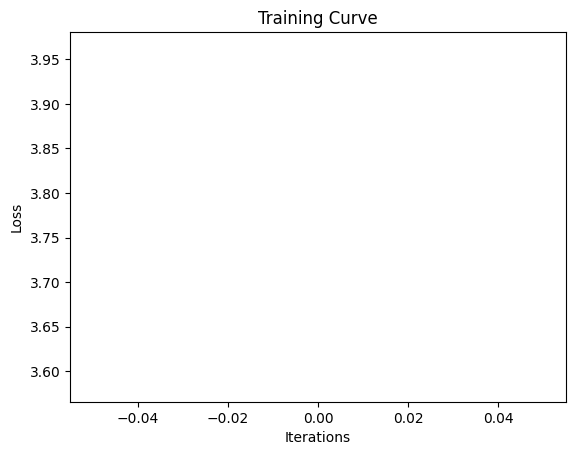

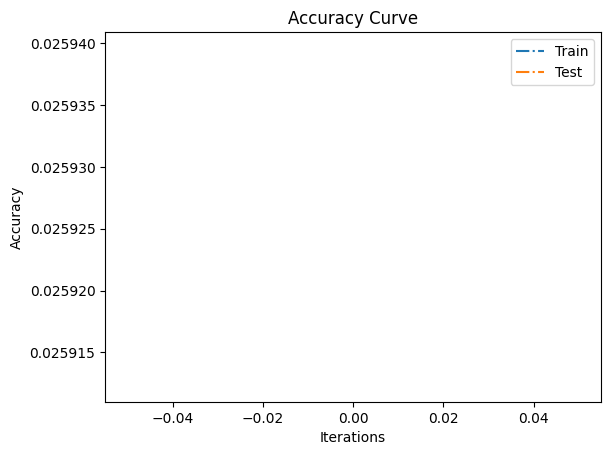

Epoch: 0, Batch: 1000 
Loss2.6653122901916504, Train Accuracy48.48%, Test Accuracy:48.90%


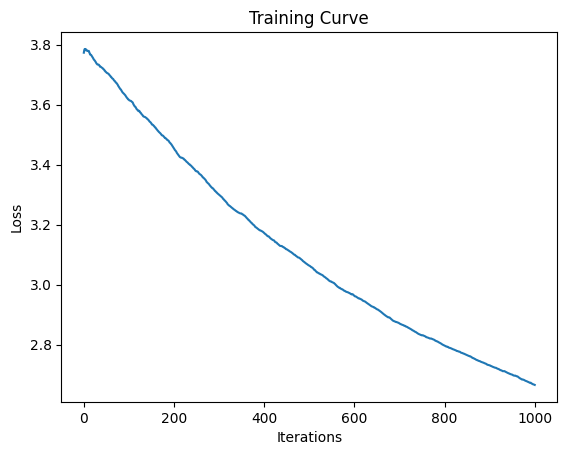

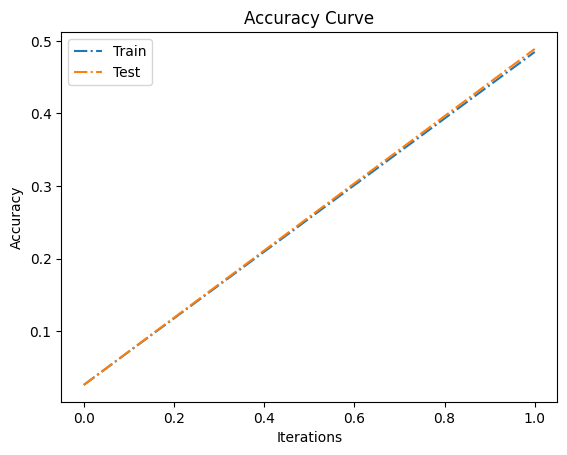

Epoch: 0, Batch: 2000 
Loss2.2170584201812744, Train Accuracy59.54%, Test Accuracy:59.93%


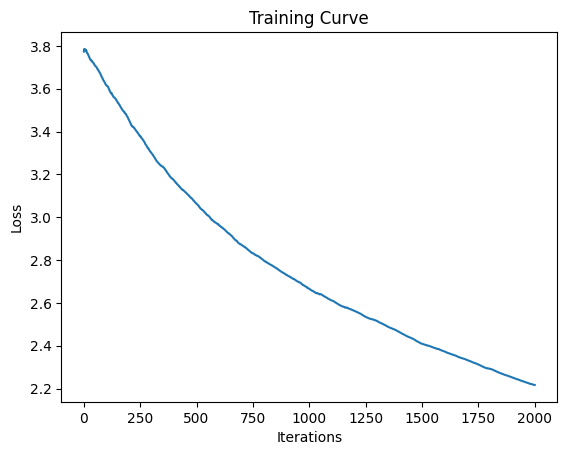

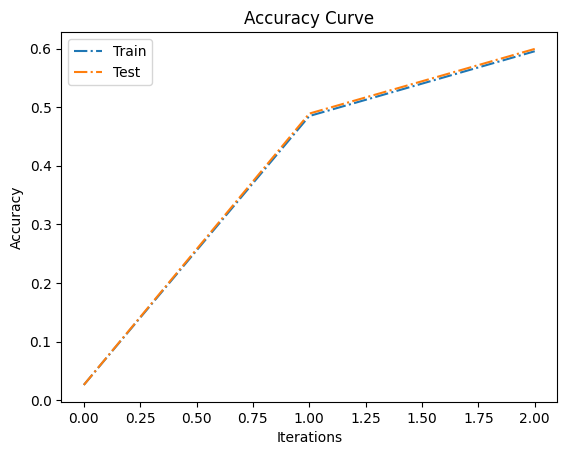

Epoch: 0, Batch: 3000 
Loss1.9708813428878784, Train Accuracy65.02%, Test Accuracy:65.10%


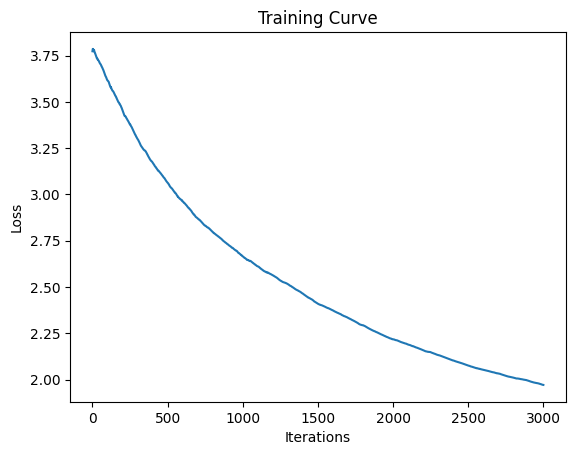

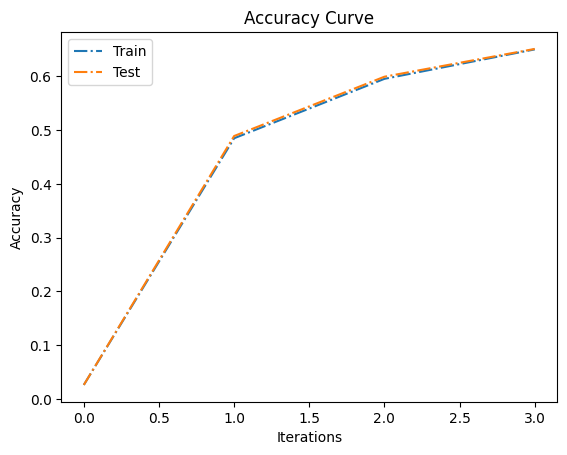

Epoch: 0, Batch: 4000 
Loss1.7732239961624146, Train Accuracy67.80%, Test Accuracy:67.95%


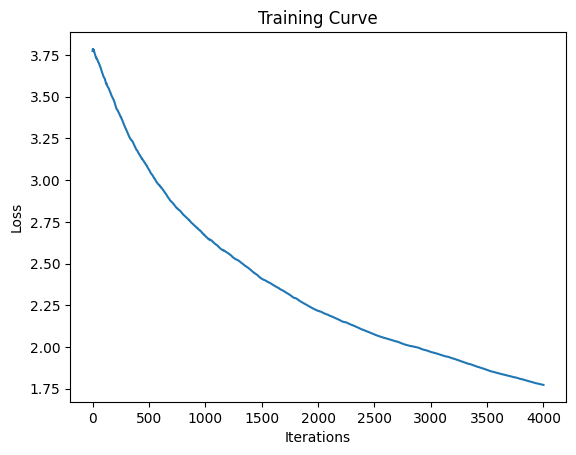

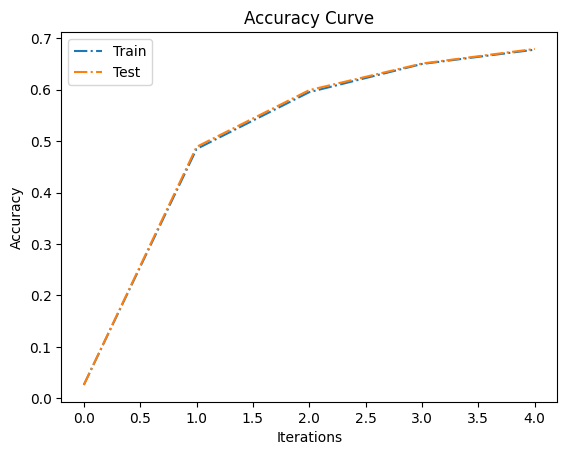

Epoch: 0, Batch: 5000 
Loss1.6404707431793213, Train Accuracy70.83%, Test Accuracy:70.98%


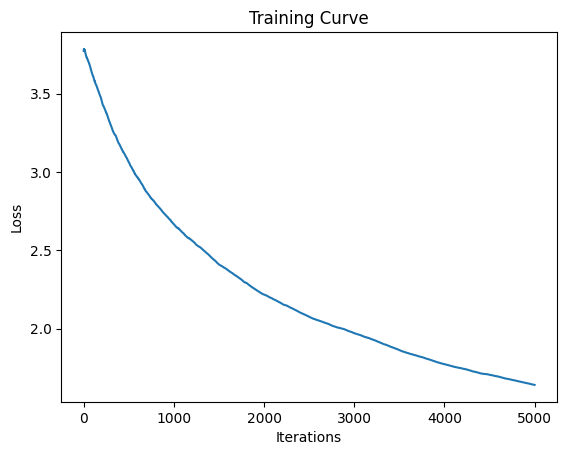

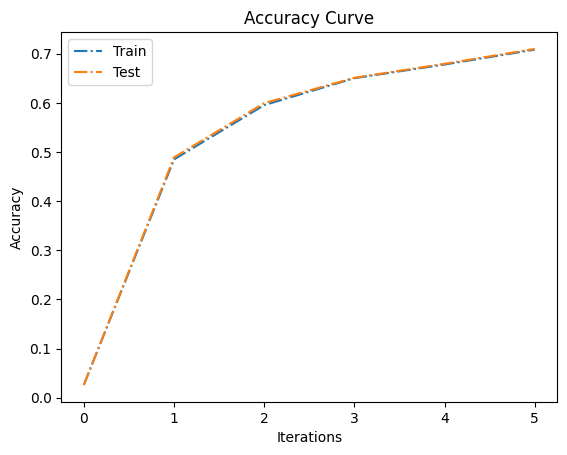

Epoch: 0, Batch: 6000 
Loss1.539839744567871, Train Accuracy73.48%, Test Accuracy:73.73%


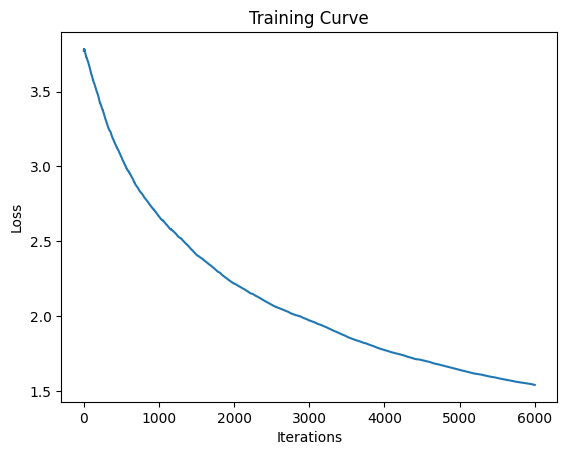

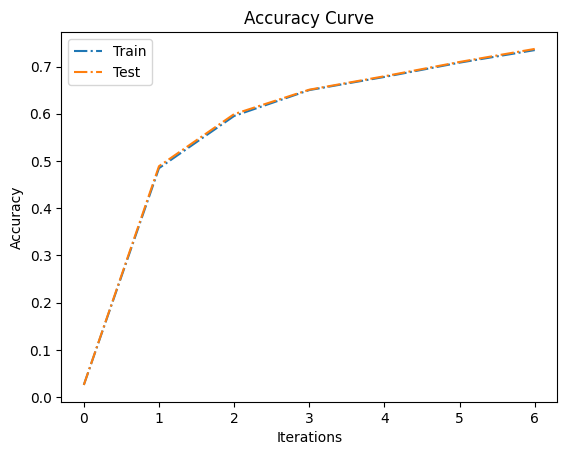

Epoch: 0, Batch: 7000 
Loss1.4445463418960571, Train Accuracy75.31%, Test Accuracy:75.41%


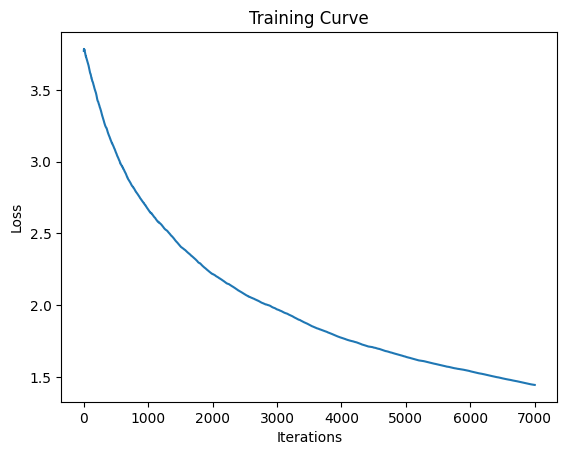

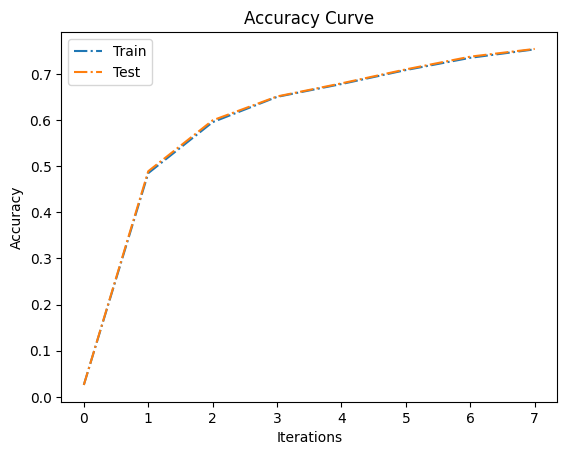

Epoch: 0, Batch: 8000 
Loss1.376361608505249, Train Accuracy76.63%, Test Accuracy:76.65%


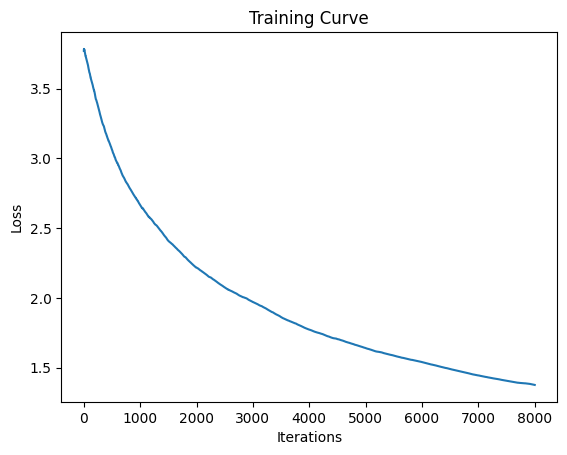

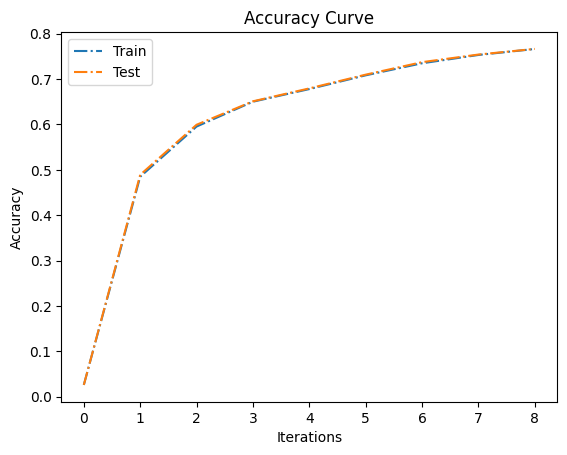

Epoch: 0, Batch: 9000 
Loss1.3135648965835571, Train Accuracy77.70%, Test Accuracy:77.62%


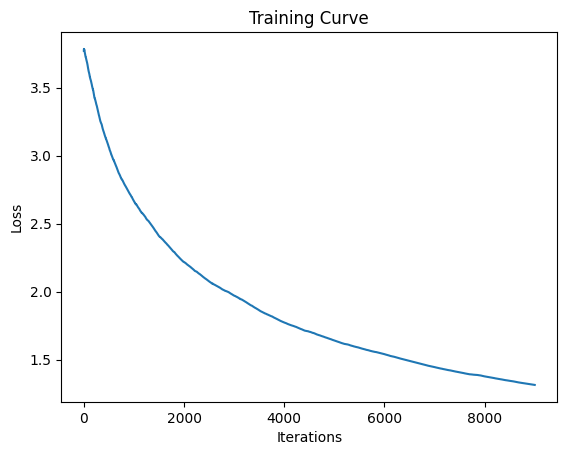

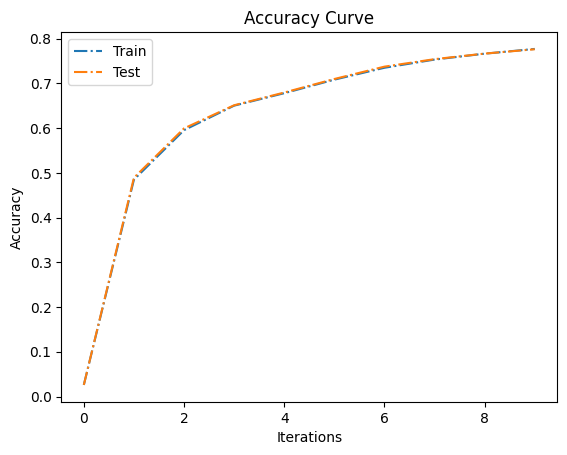

Epoch: 0, Batch: 10000 
Loss1.255150318145752, Train Accuracy78.88%, Test Accuracy:78.92%


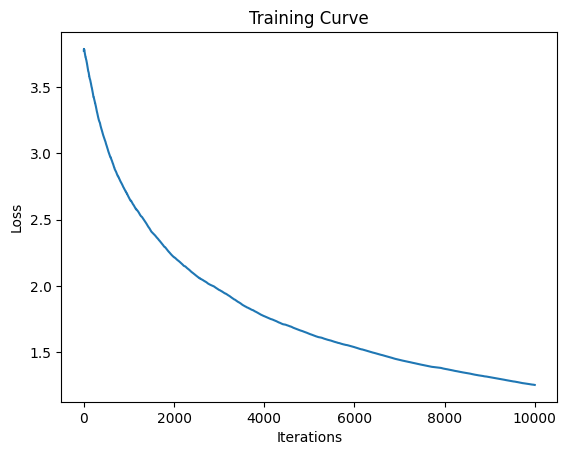

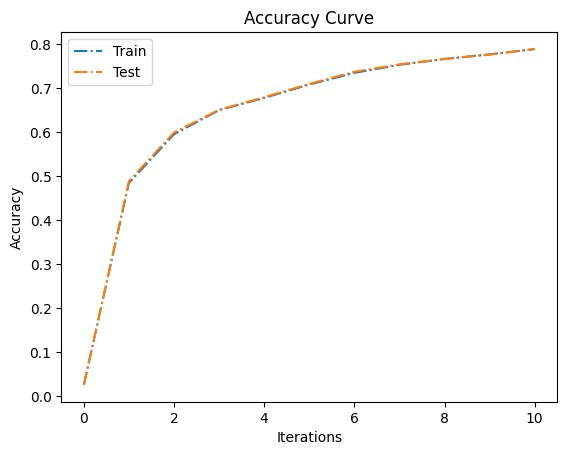

Epoch: 0, Batch: 11000 
Loss1.208309292793274, Train Accuracy79.68%, Test Accuracy:79.62%


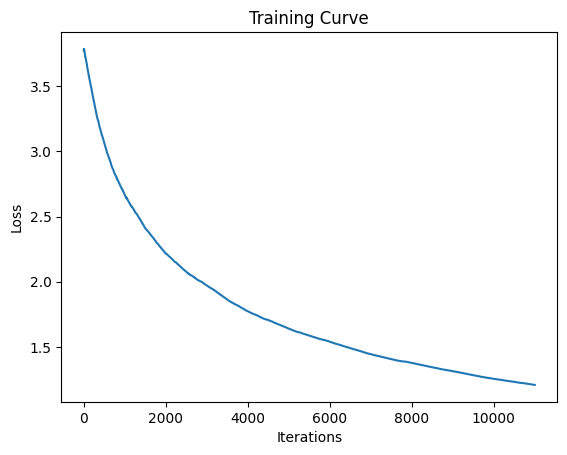

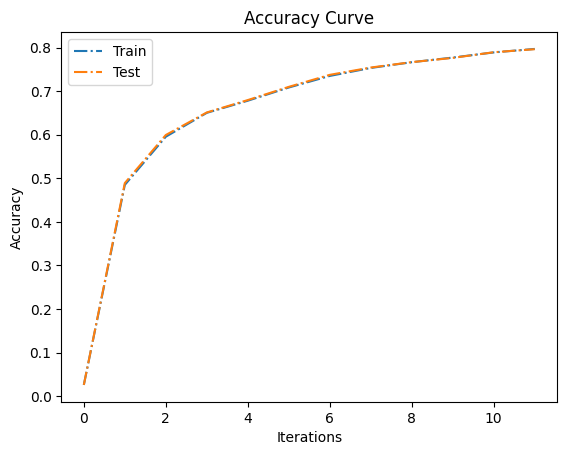

Epoch: 0, Batch: 12000 
Loss1.1658532619476318, Train Accuracy80.68%, Test Accuracy:80.59%


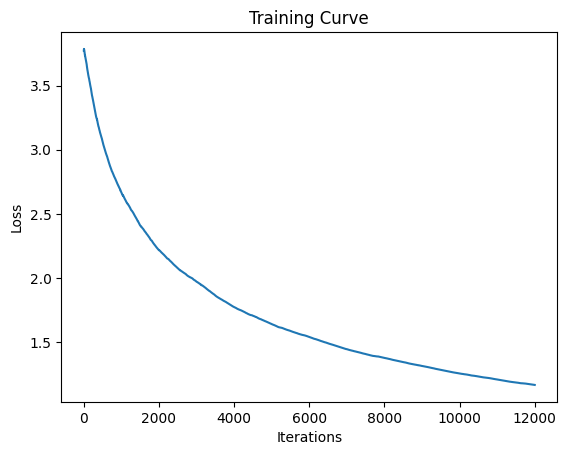

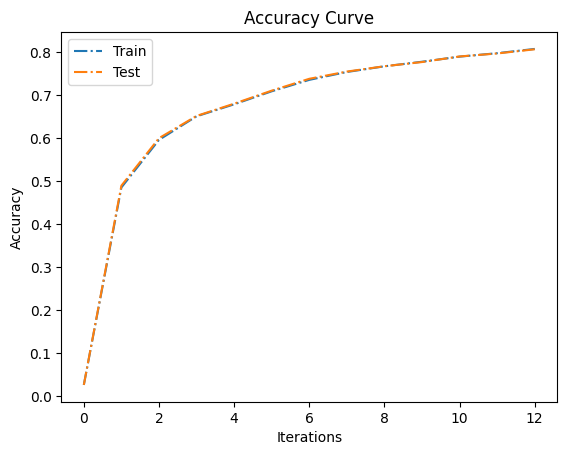

Epoch: 0, Batch: 13000 
Loss1.1248414516448975, Train Accuracy81.14%, Test Accuracy:80.91%


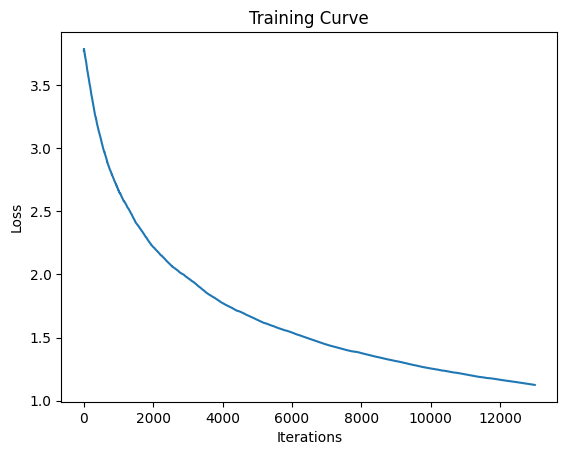

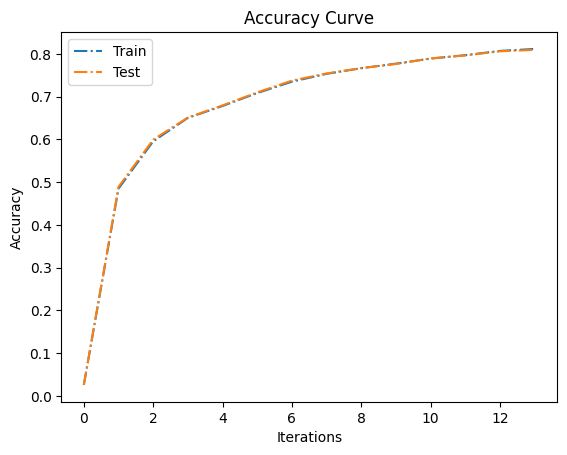

Epoch: 0, Batch: 14000 
Loss1.0911859273910522, Train Accuracy81.87%, Test Accuracy:81.72%


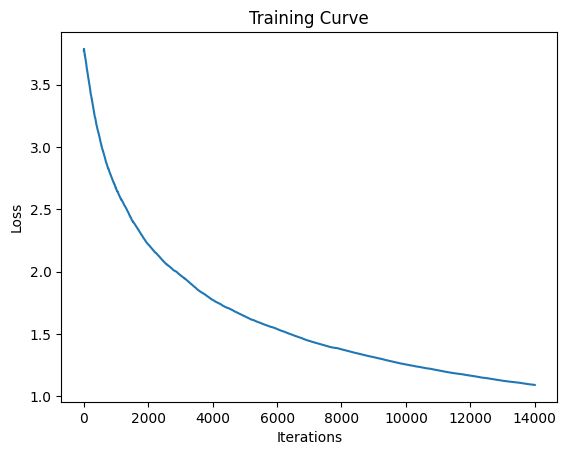

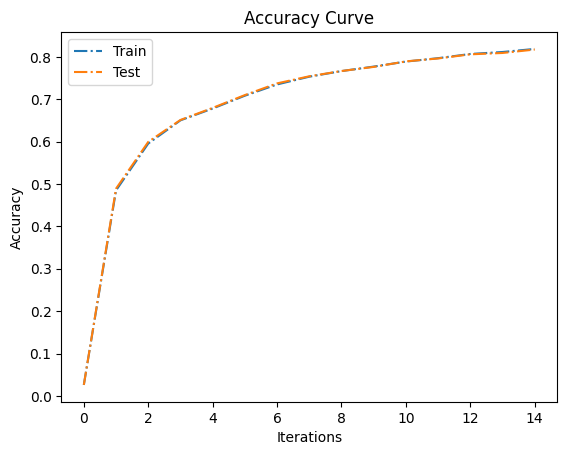

Epoch: 0, Batch: 15000 
Loss1.0625203847885132, Train Accuracy82.47%, Test Accuracy:82.24%


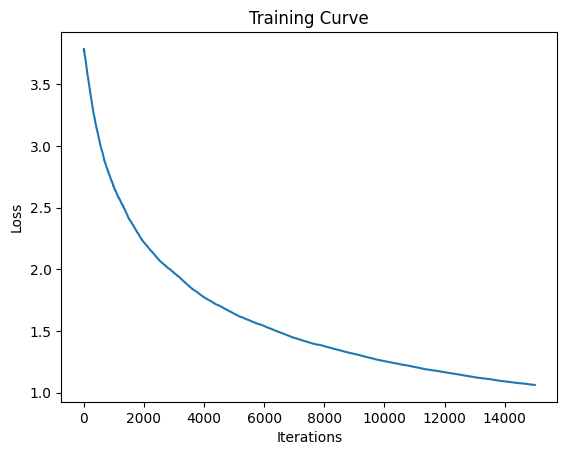

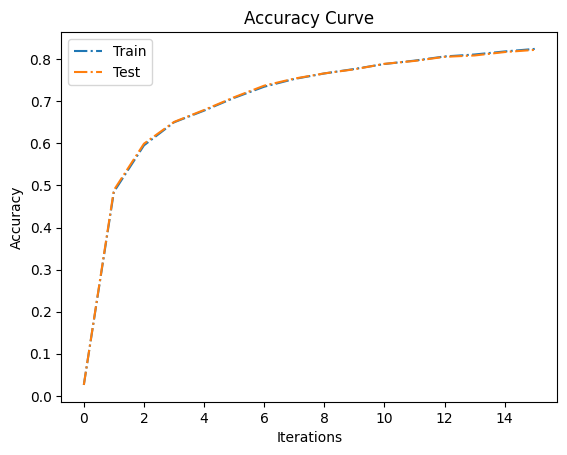

Epoch: 0, Batch: 16000 
Loss1.0333696603775024, Train Accuracy83.02%, Test Accuracy:82.79%


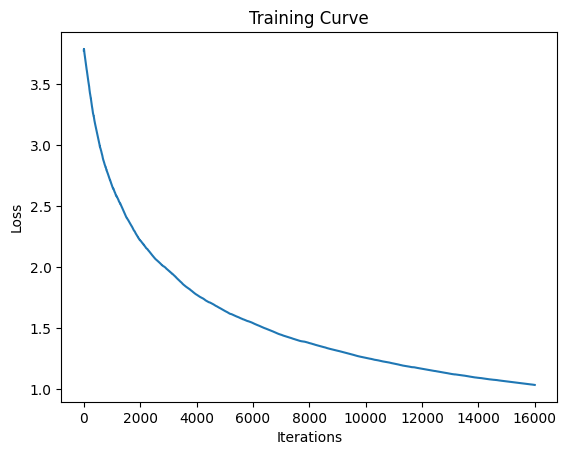

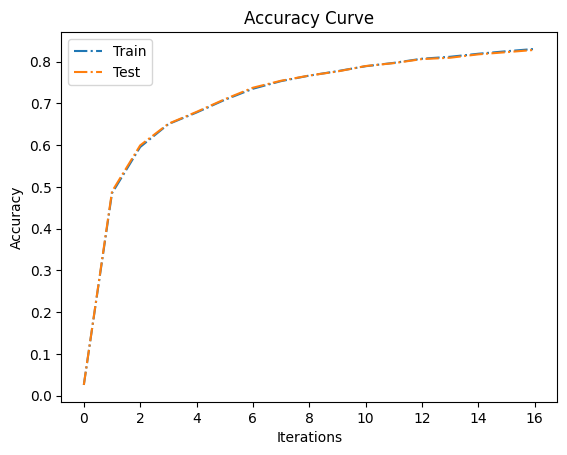

Epoch: 0, Batch: 17000 
Loss1.0067903995513916, Train Accuracy83.55%, Test Accuracy:83.19%


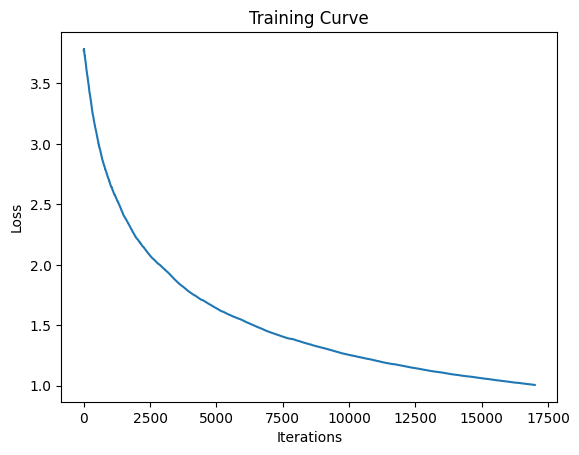

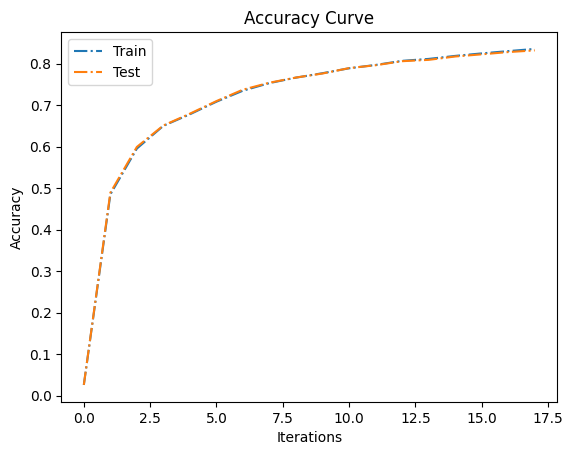

Epoch: 0, Batch: 18000 
Loss0.9822711944580078, Train Accuracy83.82%, Test Accuracy:83.52%


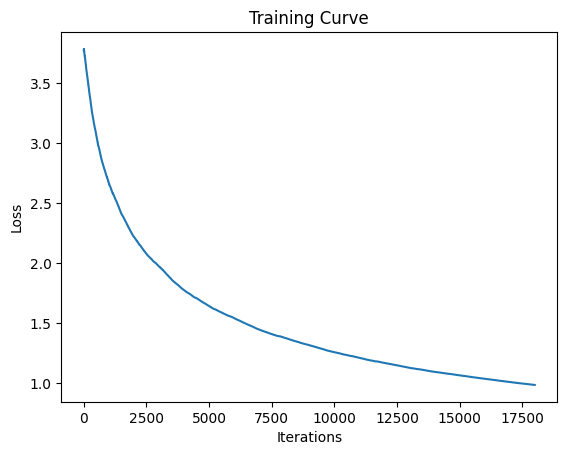

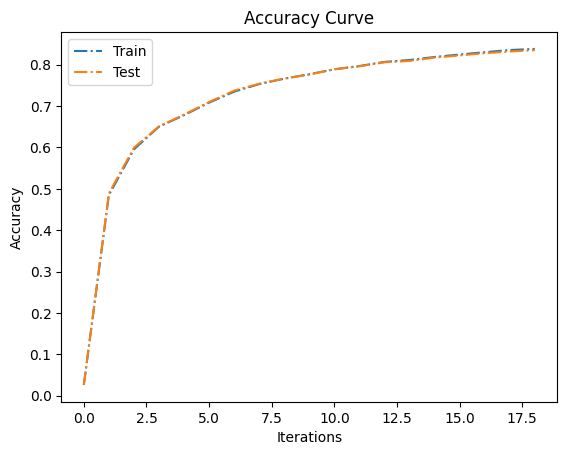

Epoch: 0, Batch: 19000 
Loss0.960205614566803, Train Accuracy84.50%, Test Accuracy:84.13%


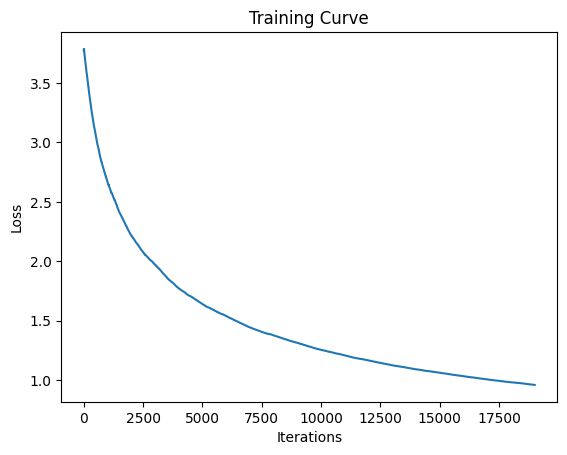

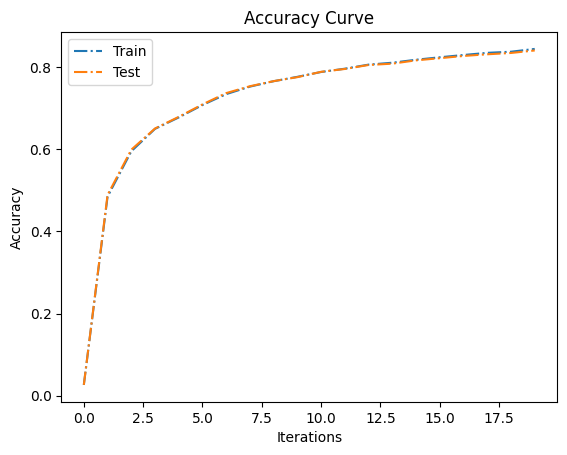

Epoch: 0, Batch: 20000 
Loss0.9385859966278076, Train Accuracy84.62%, Test Accuracy:84.23%


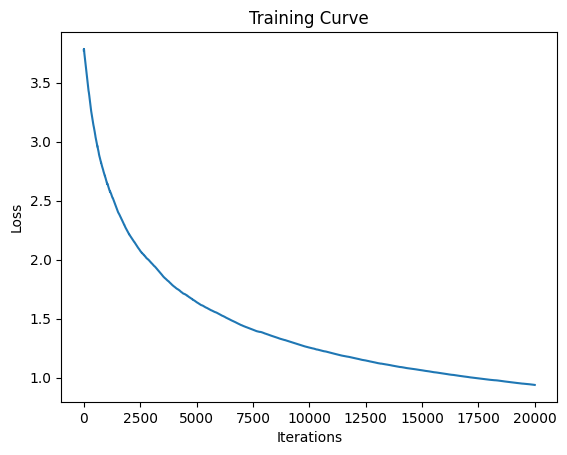

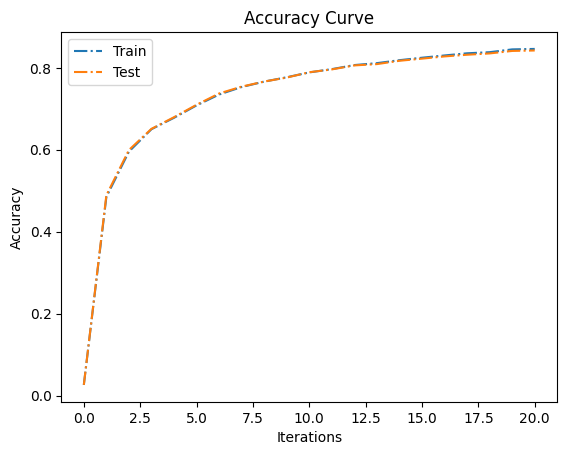

Epoch: 0, Batch: 21000 
Loss0.9201834797859192, Train Accuracy84.86%, Test Accuracy:84.32%


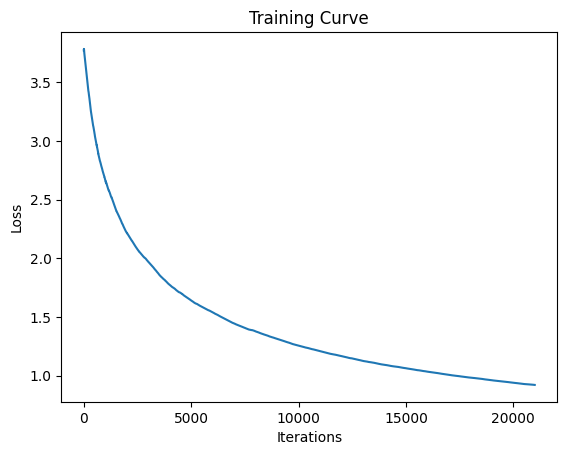

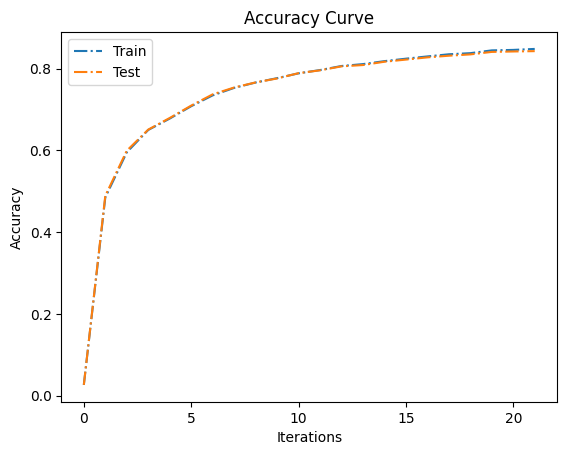

Epoch: 0, Batch: 22000 
Loss0.9043154120445251, Train Accuracy84.88%, Test Accuracy:84.44%


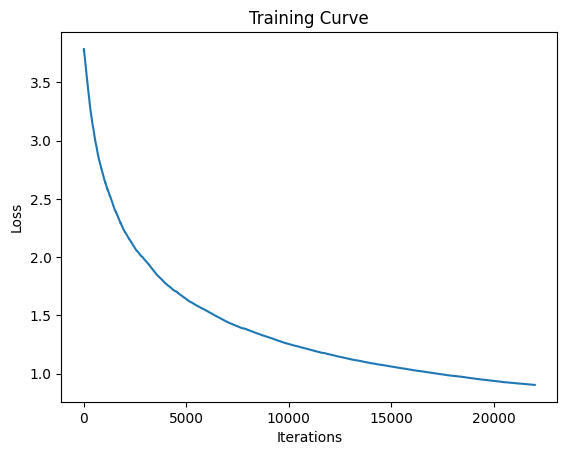

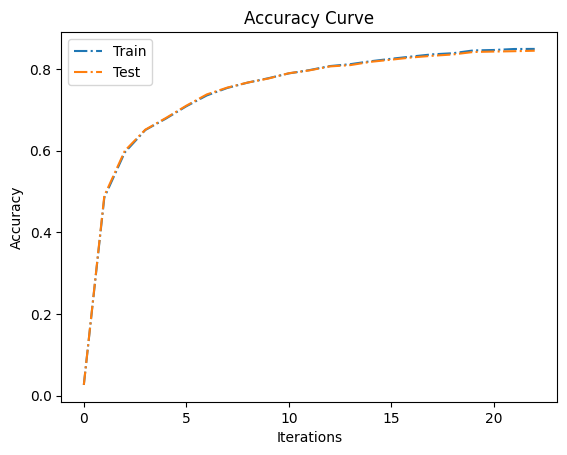

Epoch: 0, Batch: 23000 
Loss0.8858346939086914, Train Accuracy85.13%, Test Accuracy:84.85%


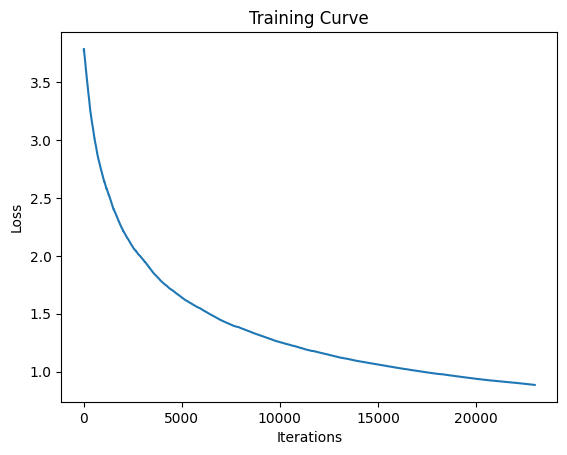

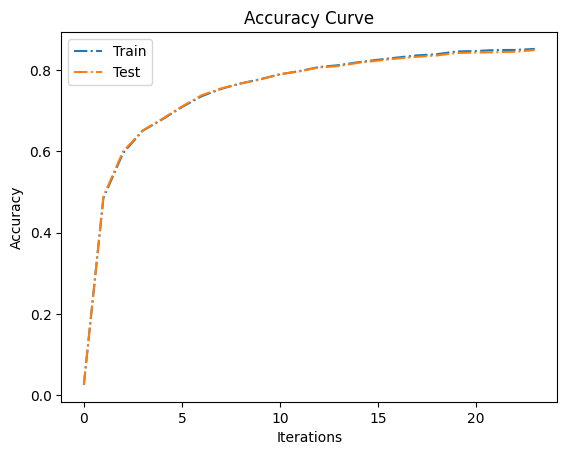

Epoch: 0, Batch: 24000 
Loss0.8718485236167908, Train Accuracy85.70%, Test Accuracy:85.34%


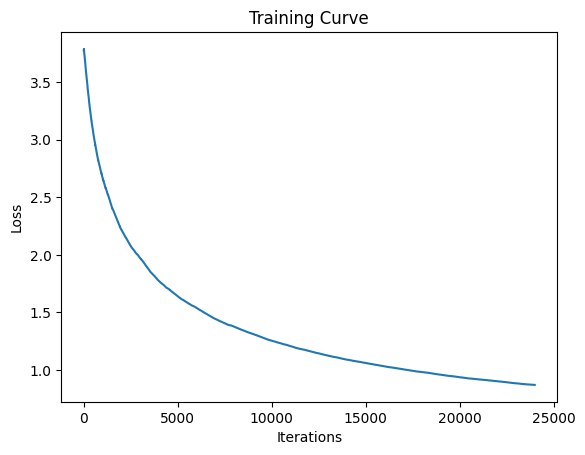

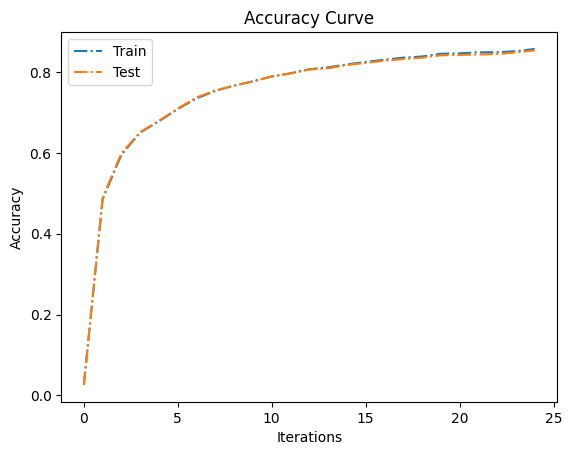

Epoch: 0, Batch: 25000 
Loss0.8547952175140381, Train Accuracy85.90%, Test Accuracy:85.47%


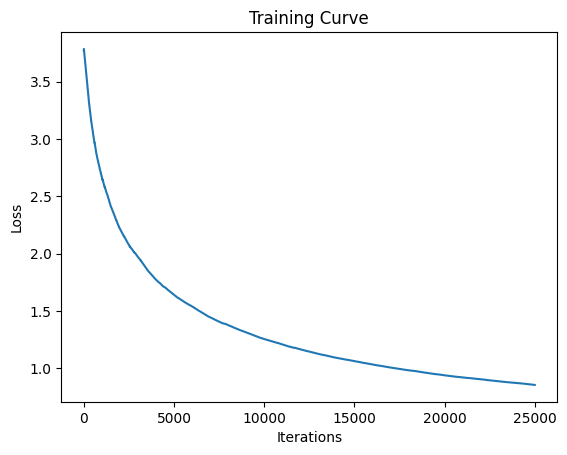

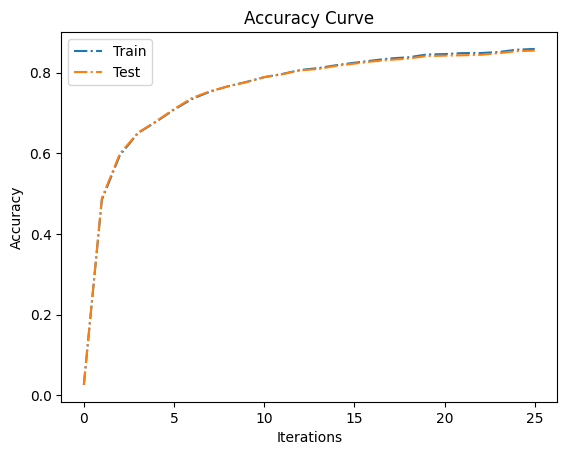

Epoch: 0, Batch: 26000 
Loss0.8397690653800964, Train Accuracy86.23%, Test Accuracy:85.70%


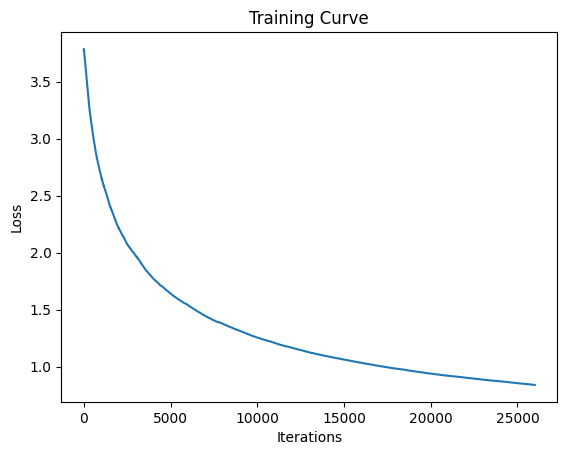

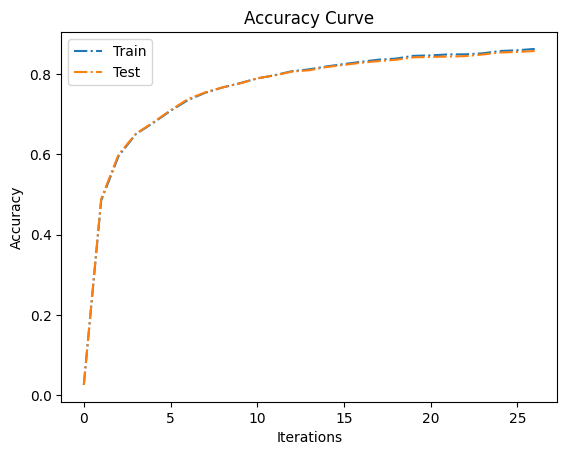

Epoch: 0, Batch: 27000 
Loss0.826924204826355, Train Accuracy86.63%, Test Accuracy:86.01%


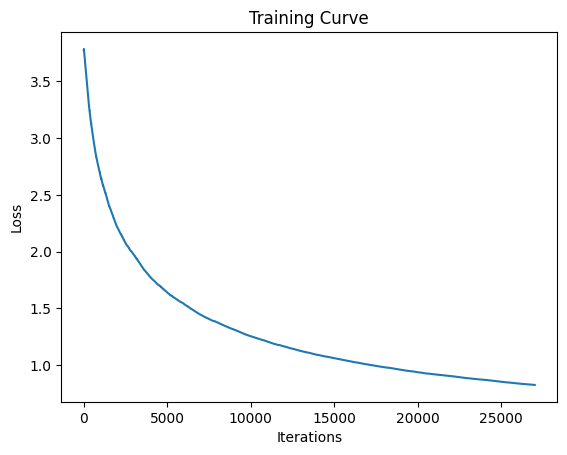

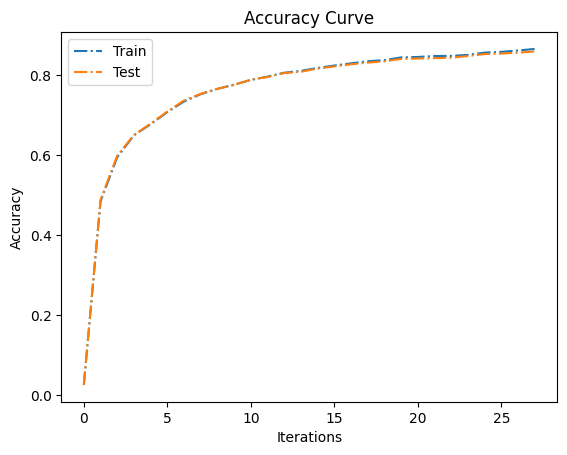

Epoch: 0, Batch: 28000 
Loss0.8148720860481262, Train Accuracy86.90%, Test Accuracy:86.24%


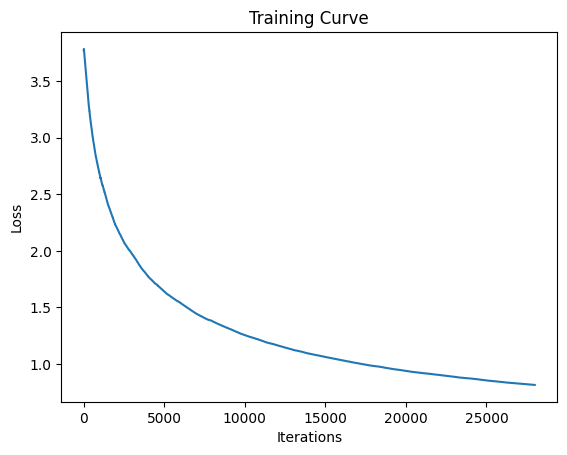

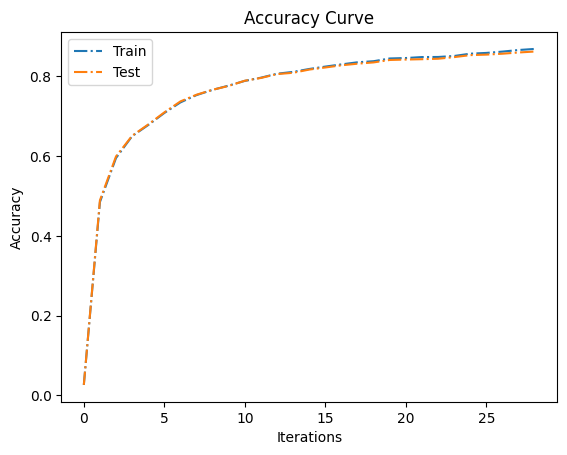

Epoch: 0, Batch: 29000 
Loss0.8028252720832825, Train Accuracy87.27%, Test Accuracy:86.77%


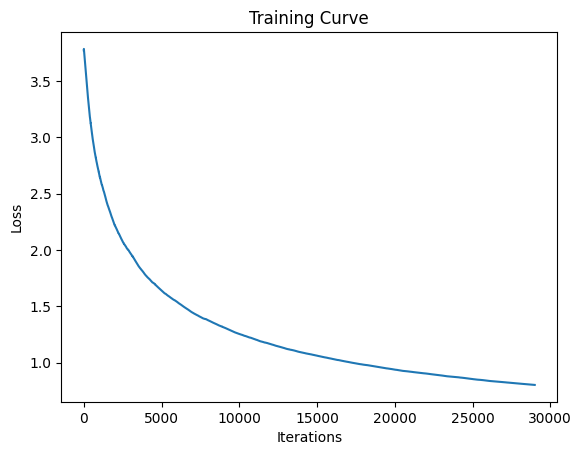

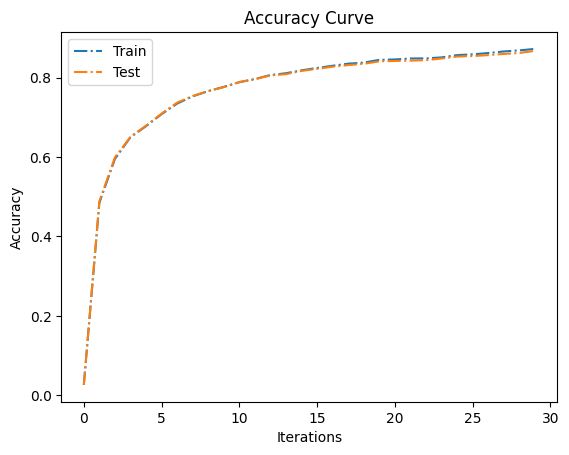

Epoch: 0, Batch: 30000 
Loss0.7911068201065063, Train Accuracy87.17%, Test Accuracy:86.54%


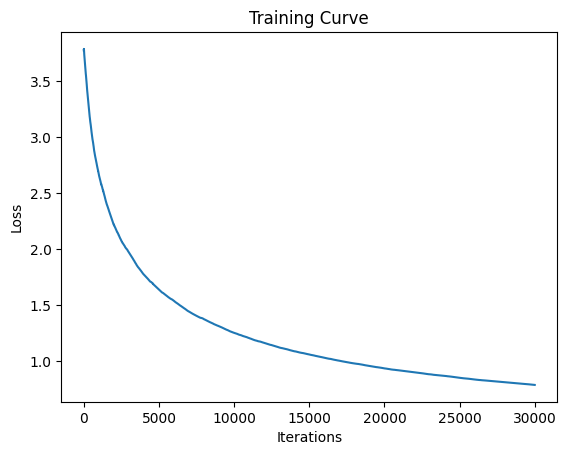

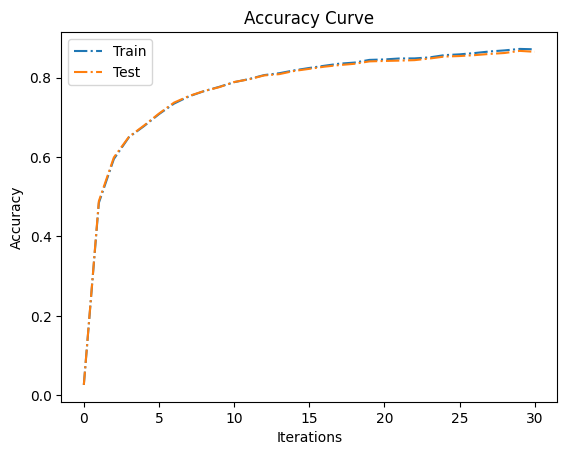

Epoch: 0, Batch: 31000 
Loss0.7810884714126587, Train Accuracy87.39%, Test Accuracy:86.85%


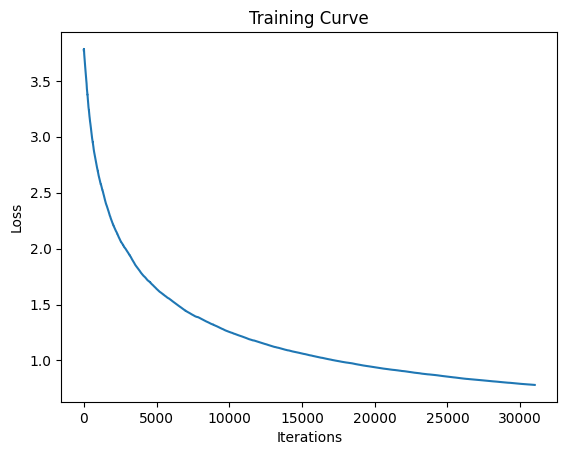

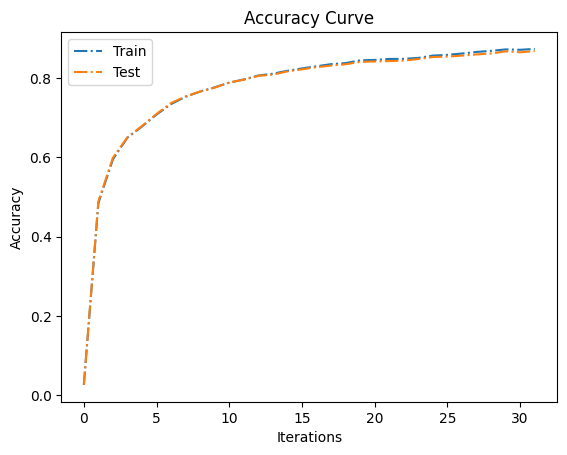

Epoch: 0, Batch: 32000 
Loss0.770706057548523, Train Accuracy87.78%, Test Accuracy:87.11%


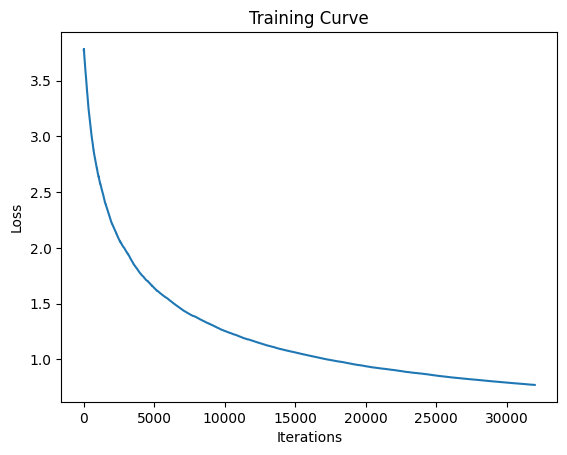

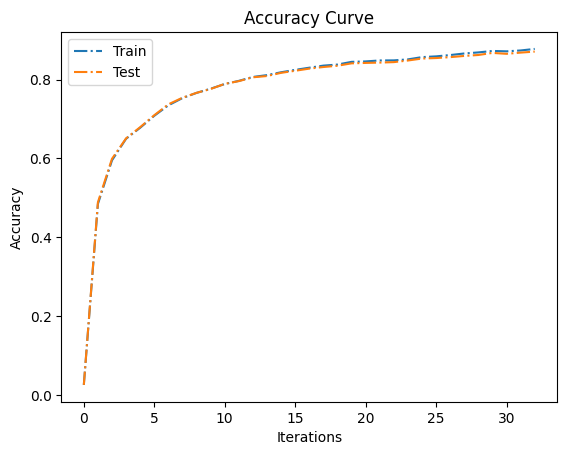

Epoch: 0, Batch: 33000 
Loss0.7600535750389099, Train Accuracy87.73%, Test Accuracy:87.07%


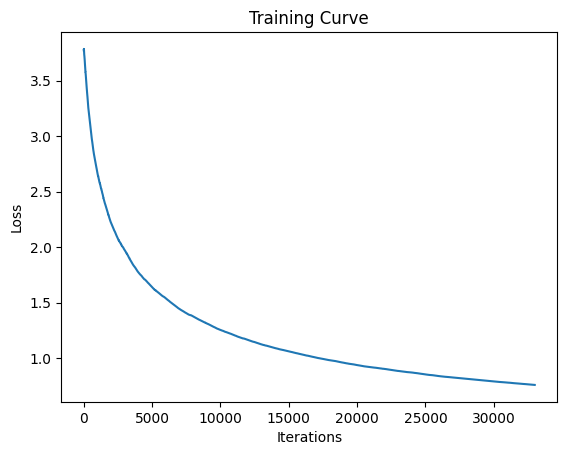

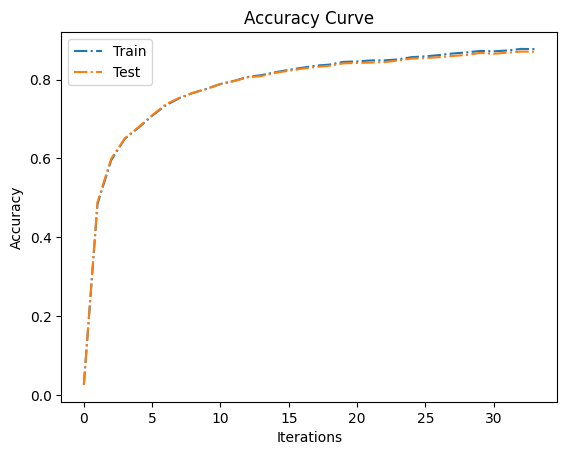

Epoch: 0, Batch: 34000 
Loss0.7496740818023682, Train Accuracy88.05%, Test Accuracy:87.44%


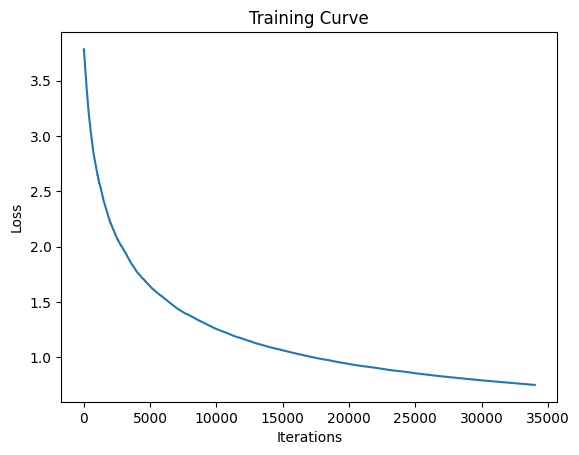

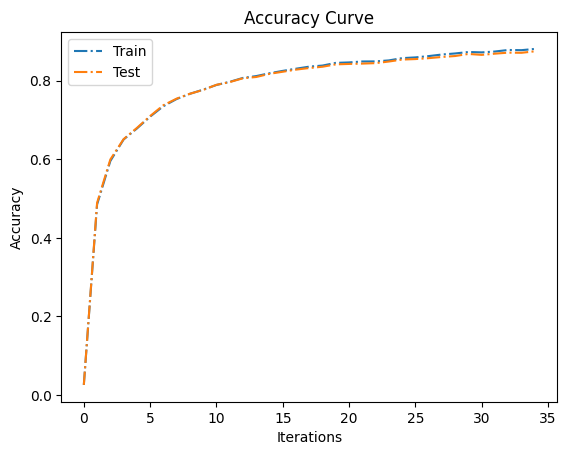

Epoch: 0, Batch: 35000 
Loss0.7403612732887268, Train Accuracy88.20%, Test Accuracy:87.63%


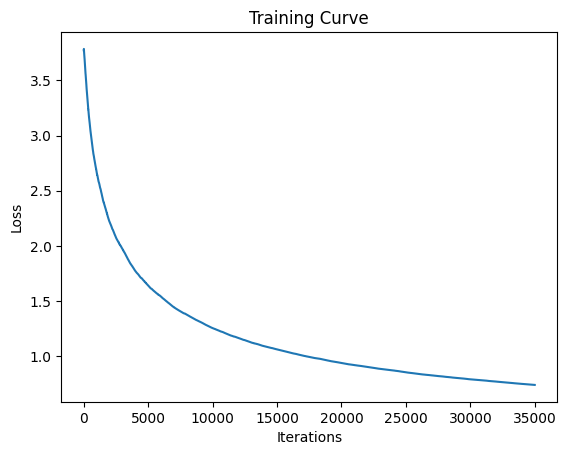

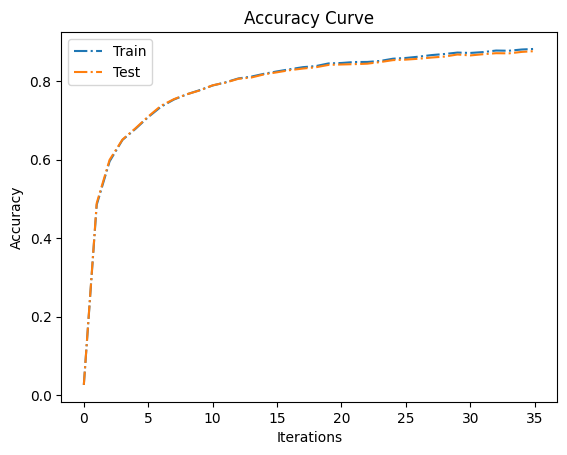

Epoch: 0, Batch: 36000 
Loss0.7331668734550476, Train Accuracy88.38%, Test Accuracy:87.79%


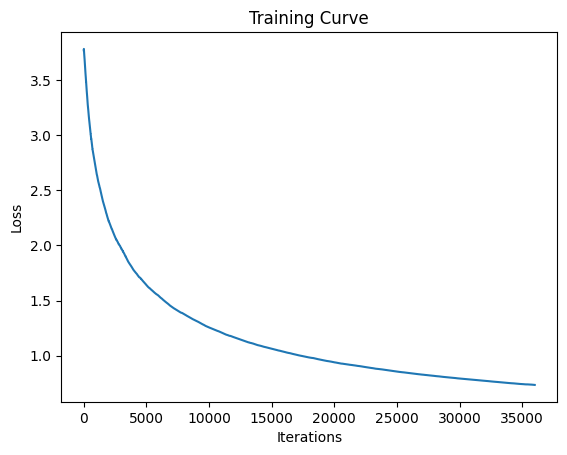

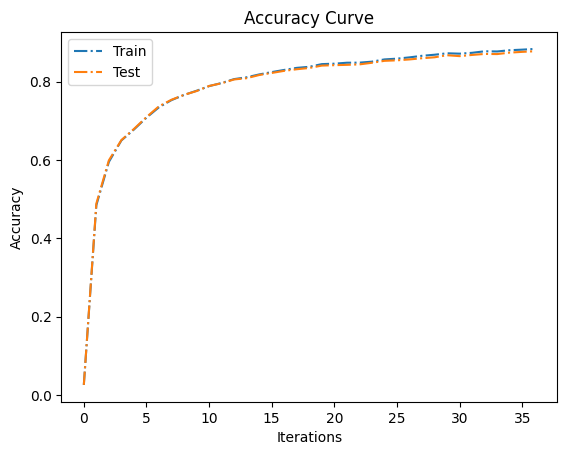

Epoch: 0, Batch: 37000 
Loss0.7251047492027283, Train Accuracy88.54%, Test Accuracy:87.87%


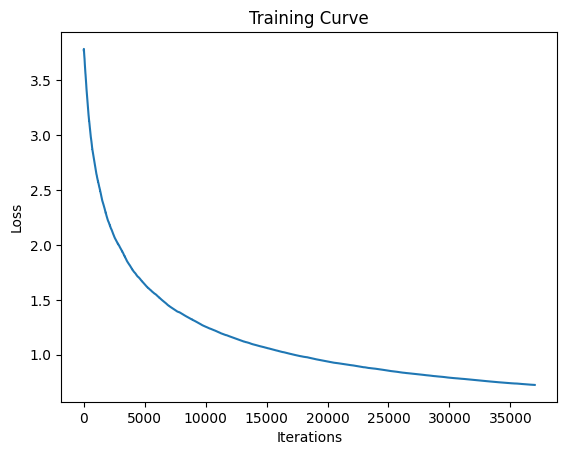

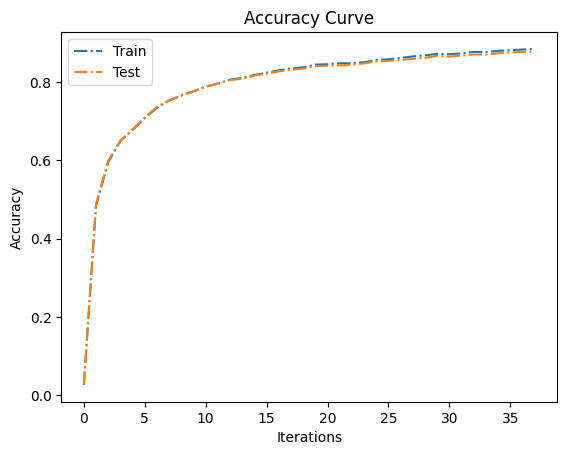

Epoch: 0, Batch: 38000 
Loss0.7160459160804749, Train Accuracy88.74%, Test Accuracy:88.12%


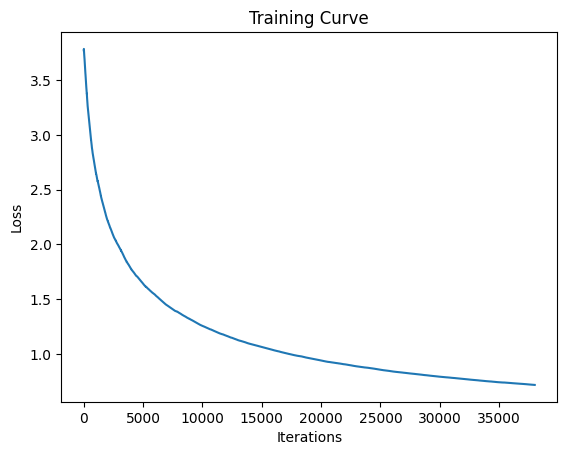

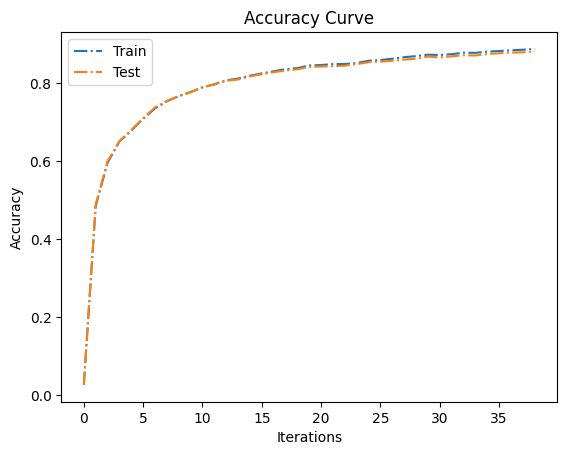

Epoch: 1, Batch: 0 
Loss0.33169296383857727, Train Accuracy88.86%, Test Accuracy:88.19%


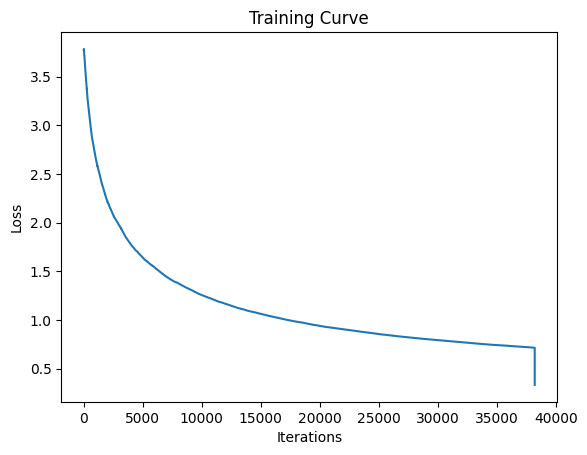

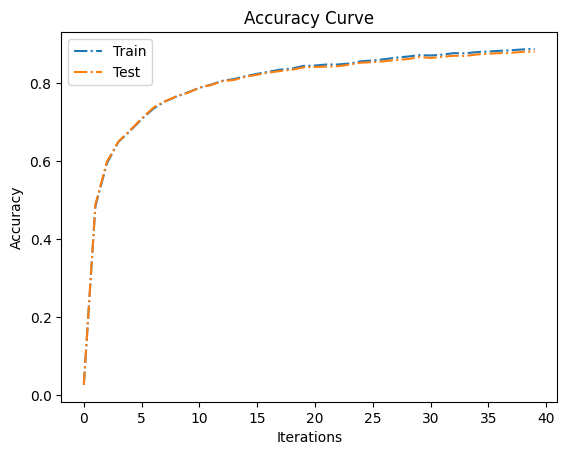

Epoch: 1, Batch: 1000 
Loss0.4104822278022766, Train Accuracy88.96%, Test Accuracy:88.30%


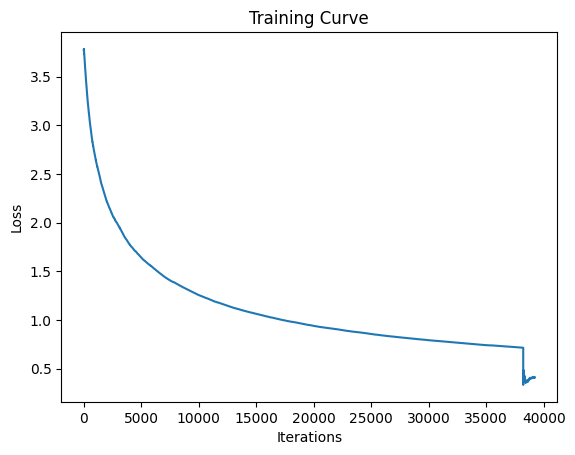

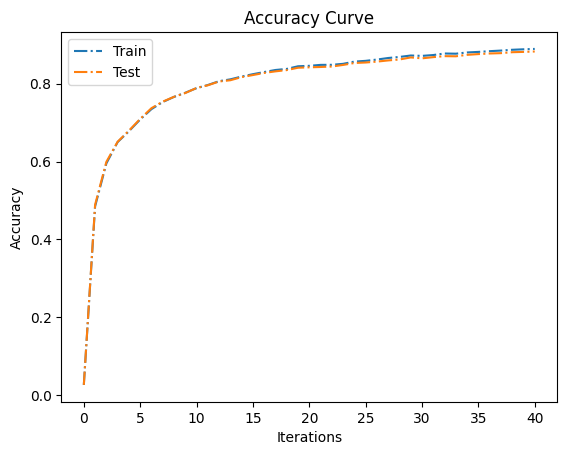

Epoch: 1, Batch: 2000 
Loss0.401766300201416, Train Accuracy89.09%, Test Accuracy:88.36%


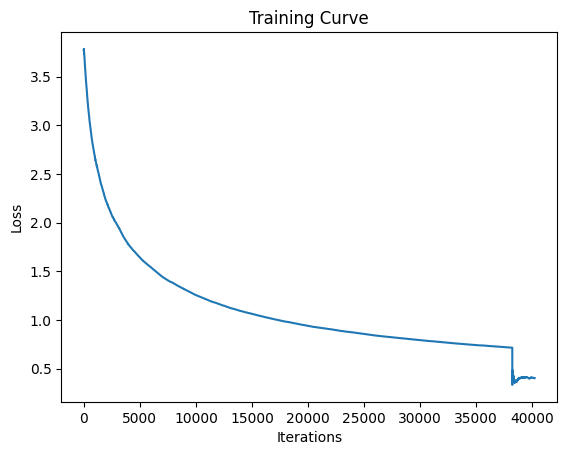

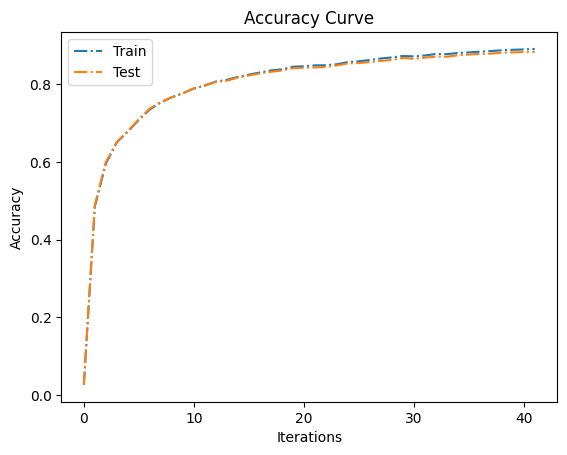

Epoch: 1, Batch: 3000 
Loss0.3964574933052063, Train Accuracy89.22%, Test Accuracy:88.45%


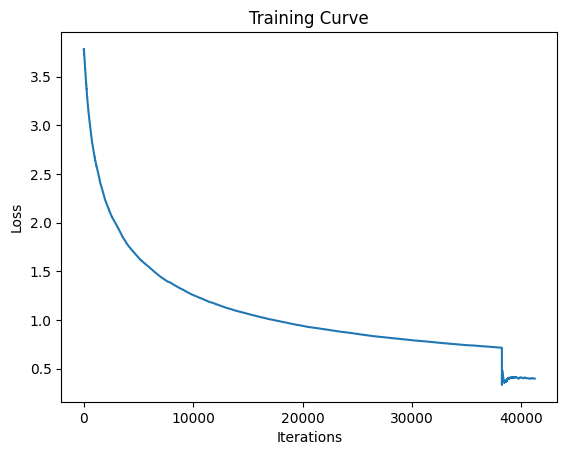

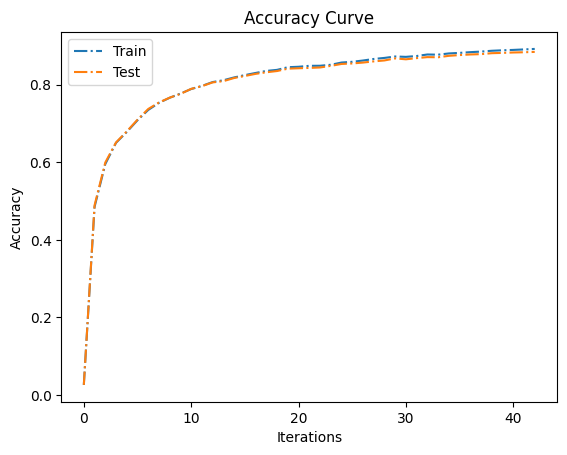

Epoch: 1, Batch: 4000 
Loss0.37903904914855957, Train Accuracy89.09%, Test Accuracy:88.30%


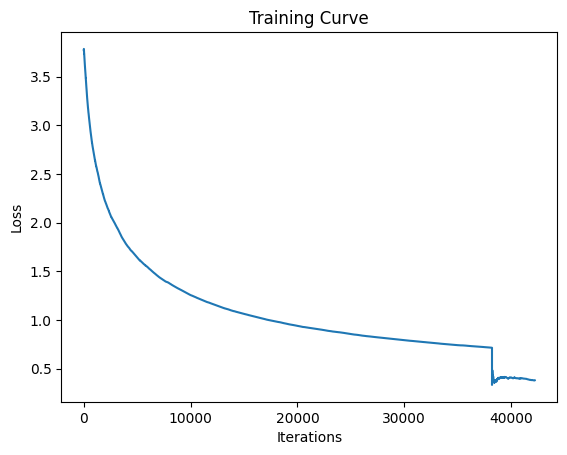

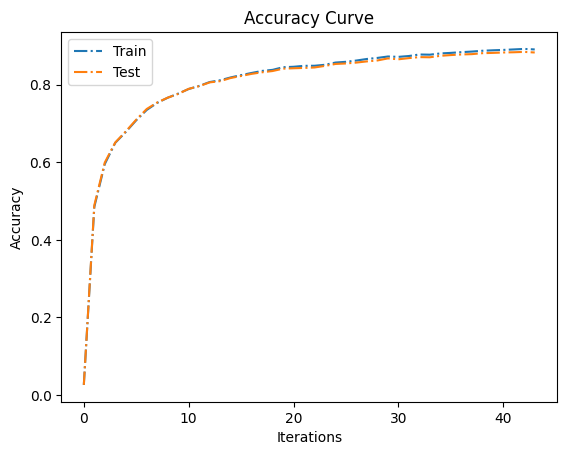

Epoch: 1, Batch: 5000 
Loss0.3828435242176056, Train Accuracy89.23%, Test Accuracy:88.40%


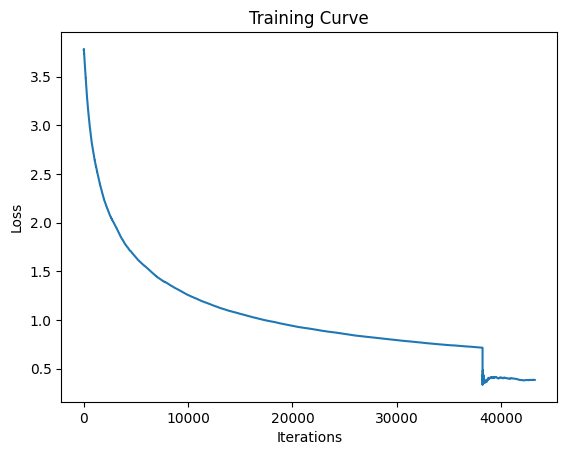

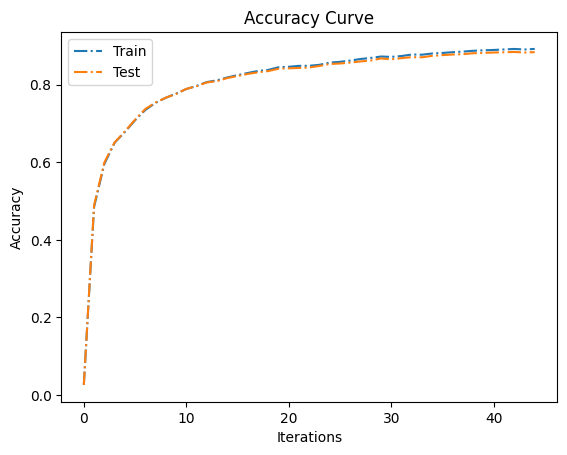

Epoch: 1, Batch: 6000 
Loss0.38665562868118286, Train Accuracy89.77%, Test Accuracy:88.94%


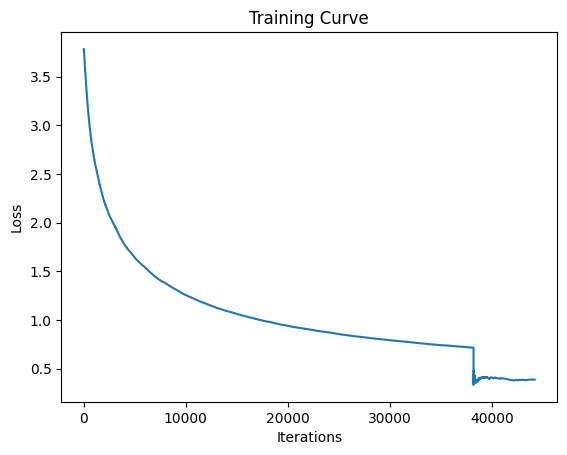

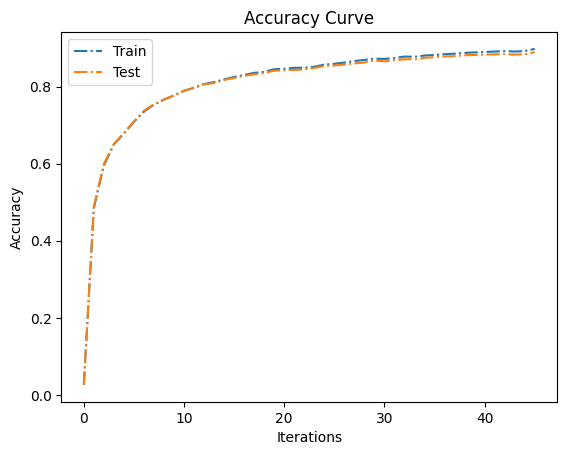

Epoch: 1, Batch: 7000 
Loss0.3758056163787842, Train Accuracy89.32%, Test Accuracy:88.43%


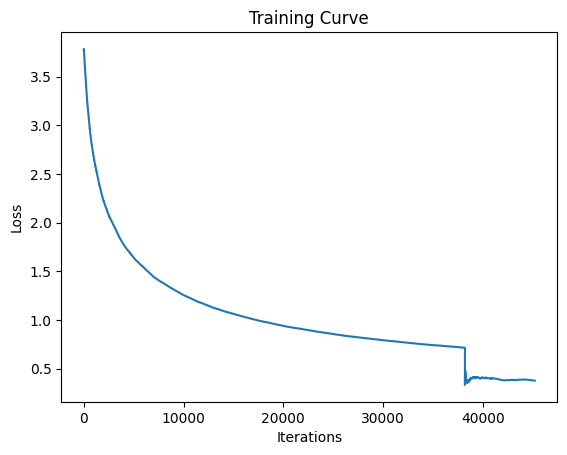

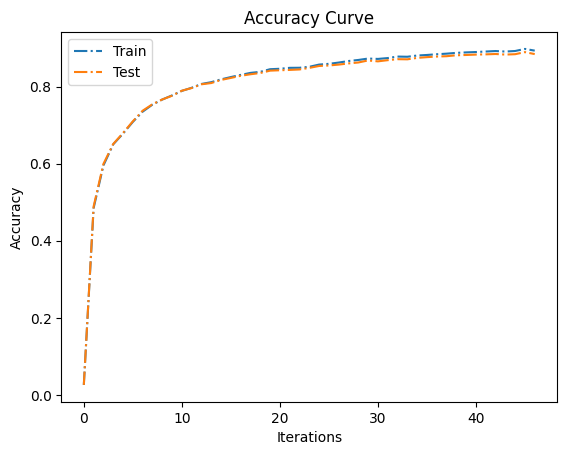

Epoch: 1, Batch: 8000 
Loss0.37773966789245605, Train Accuracy89.81%, Test Accuracy:88.88%


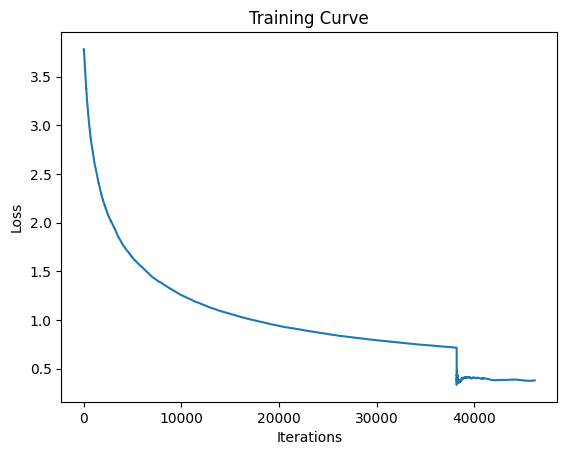

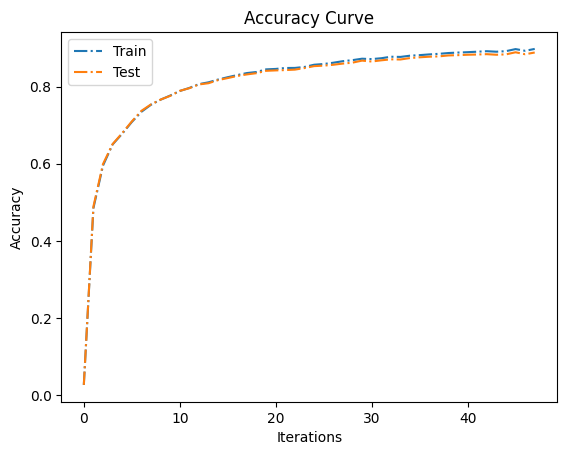

Epoch: 1, Batch: 9000 
Loss0.3750780522823334, Train Accuracy89.94%, Test Accuracy:88.92%


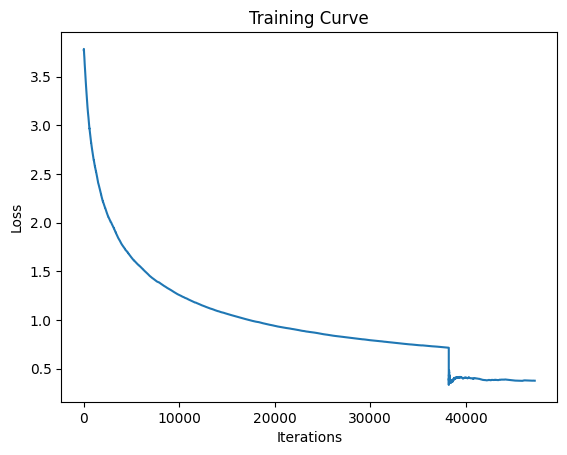

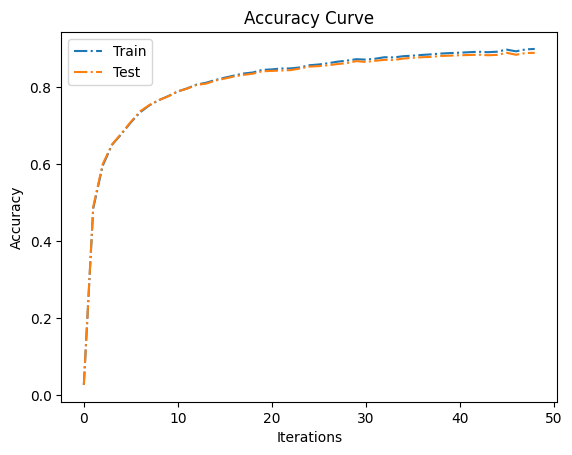

Epoch: 1, Batch: 10000 
Loss0.37008020281791687, Train Accuracy89.90%, Test Accuracy:89.09%


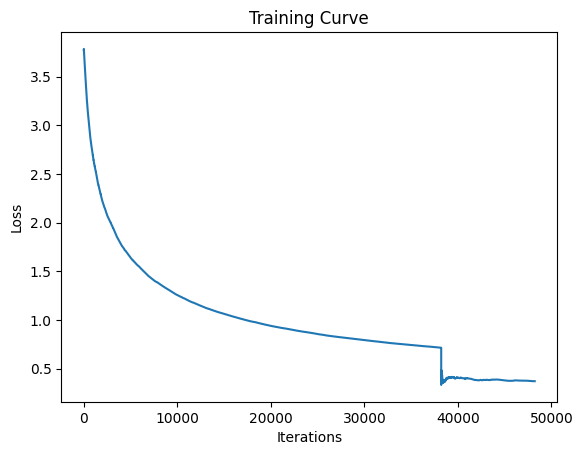

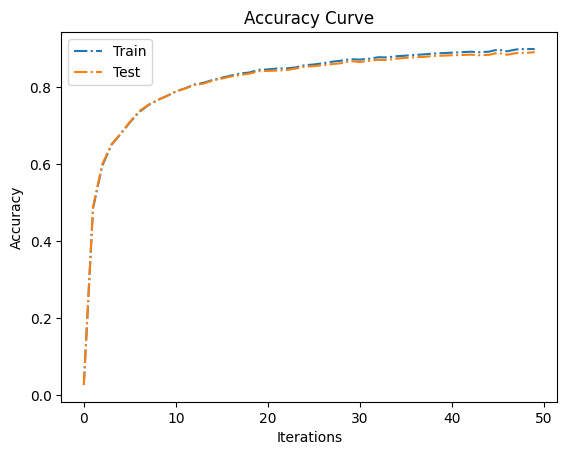

Epoch: 1, Batch: 11000 
Loss0.36835798621177673, Train Accuracy90.17%, Test Accuracy:89.36%


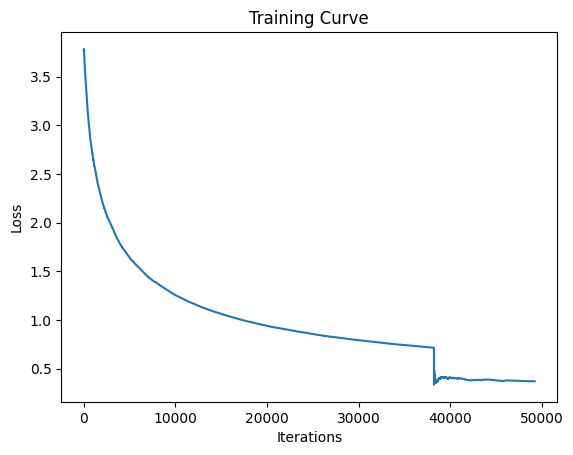

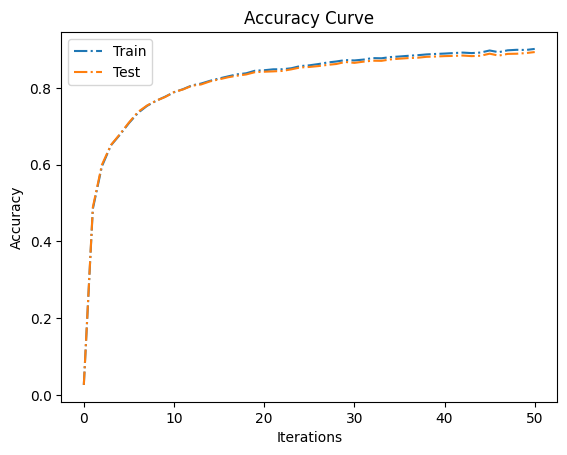

Epoch: 1, Batch: 12000 
Loss0.36516183614730835, Train Accuracy90.25%, Test Accuracy:89.37%


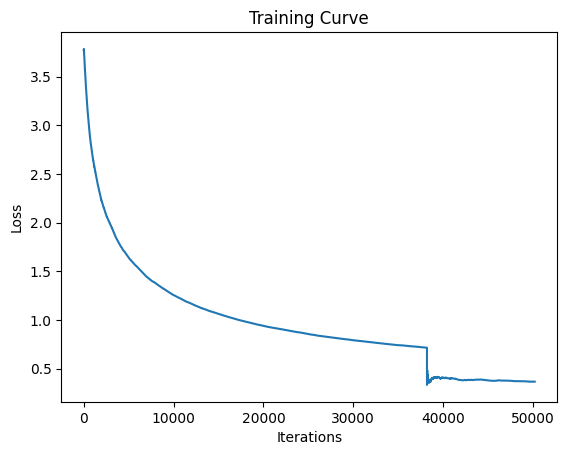

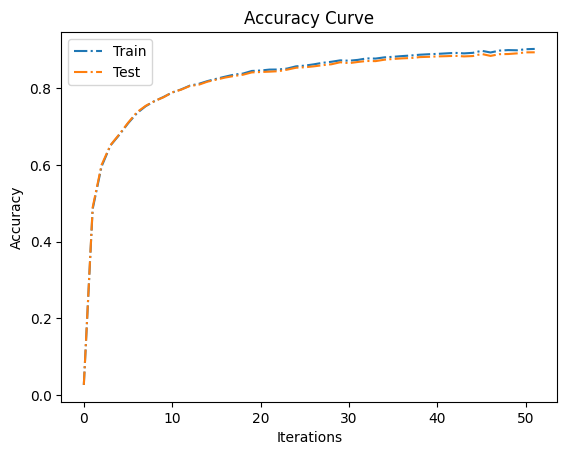

Epoch: 1, Batch: 13000 
Loss0.36063674092292786, Train Accuracy90.26%, Test Accuracy:89.23%


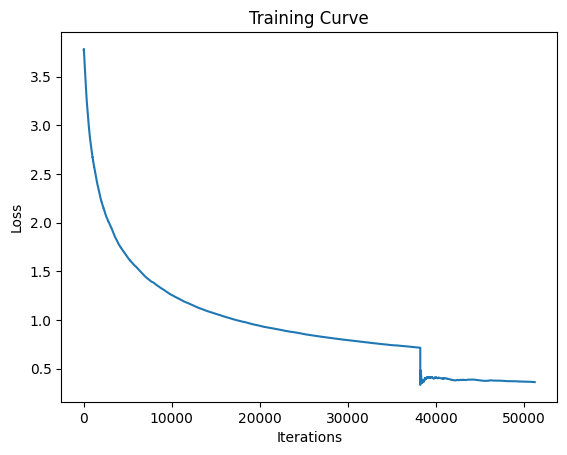

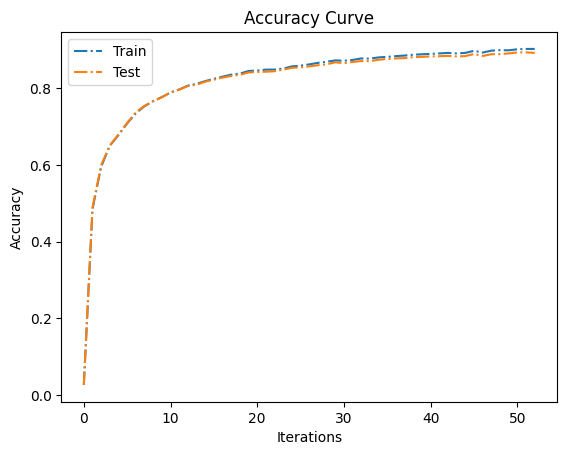

Epoch: 1, Batch: 14000 
Loss0.3585050404071808, Train Accuracy90.28%, Test Accuracy:89.32%


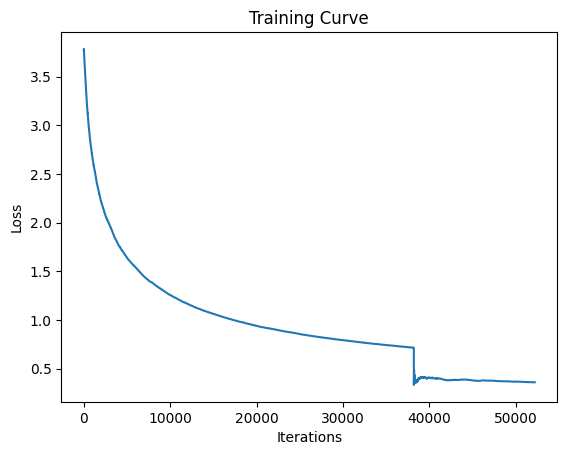

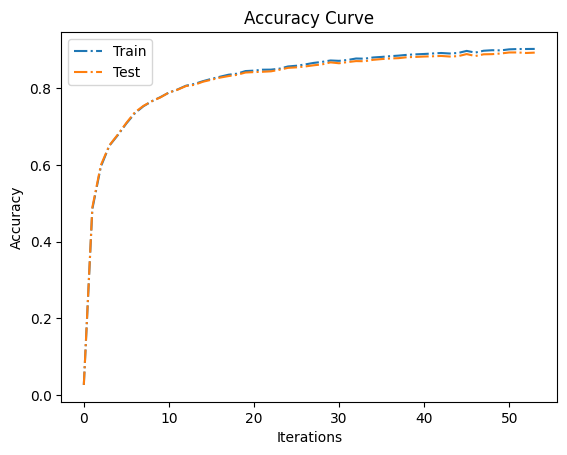

Epoch: 1, Batch: 15000 
Loss0.3586343228816986, Train Accuracy90.30%, Test Accuracy:89.30%


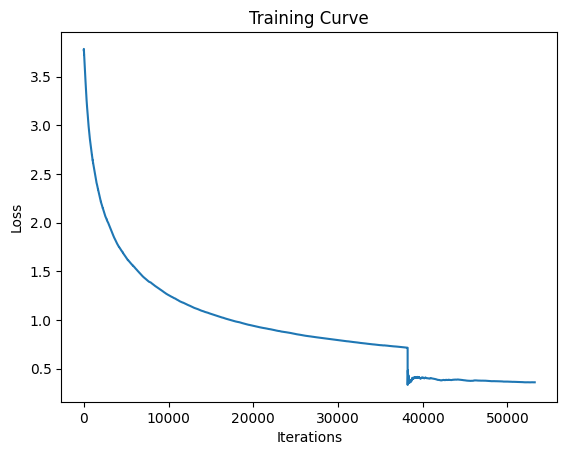

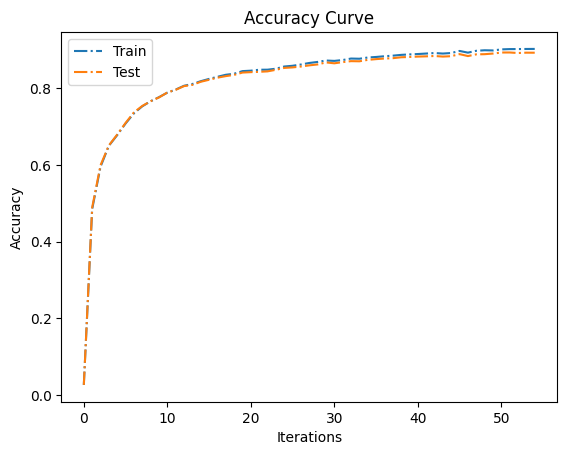

Epoch: 1, Batch: 16000 
Loss0.3561774492263794, Train Accuracy90.46%, Test Accuracy:89.43%


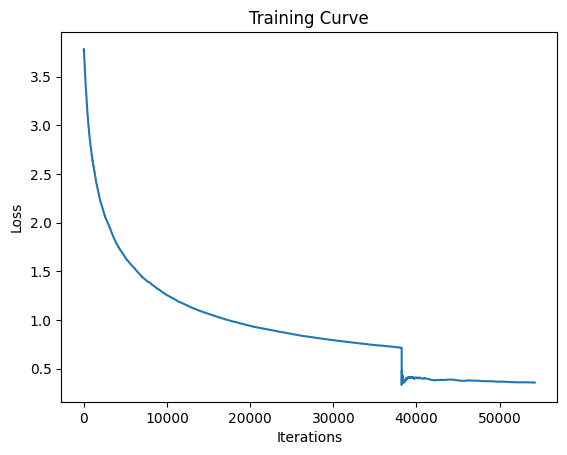

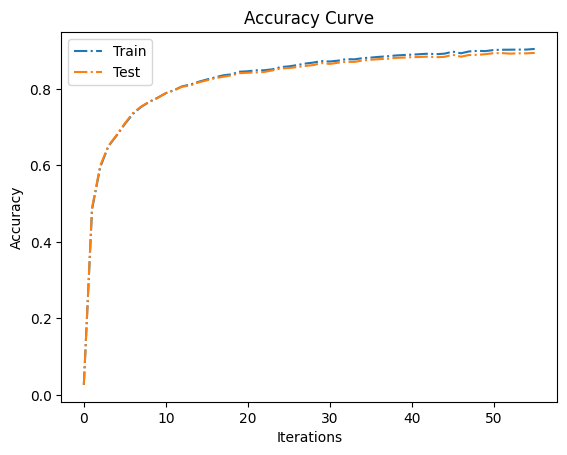

Epoch: 1, Batch: 17000 
Loss0.35434481501579285, Train Accuracy90.84%, Test Accuracy:89.86%


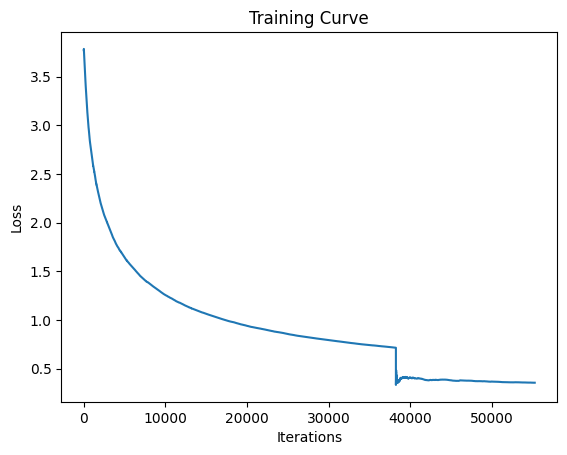

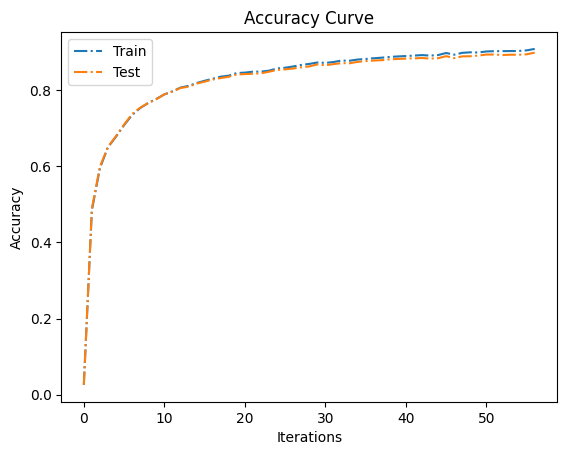

Epoch: 1, Batch: 18000 
Loss0.3522399067878723, Train Accuracy90.88%, Test Accuracy:89.96%


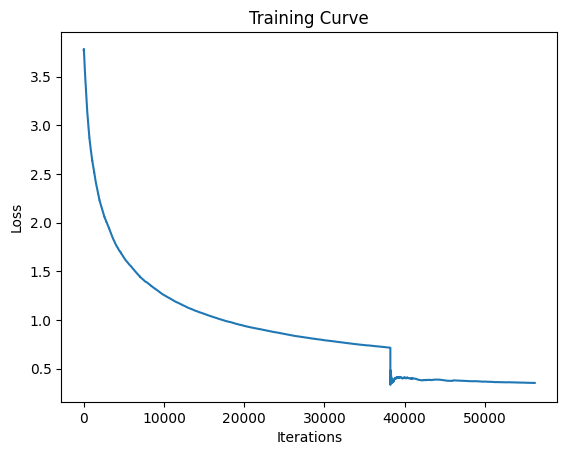

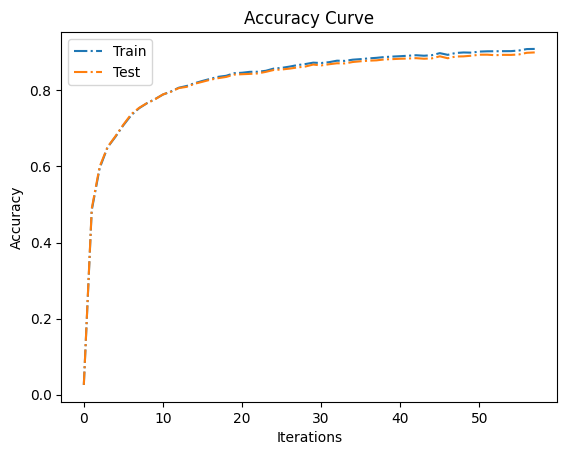

Epoch: 1, Batch: 19000 
Loss0.3503631353378296, Train Accuracy91.15%, Test Accuracy:90.04%


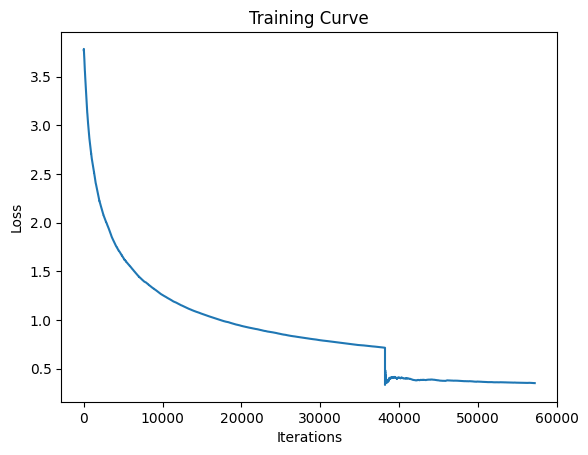

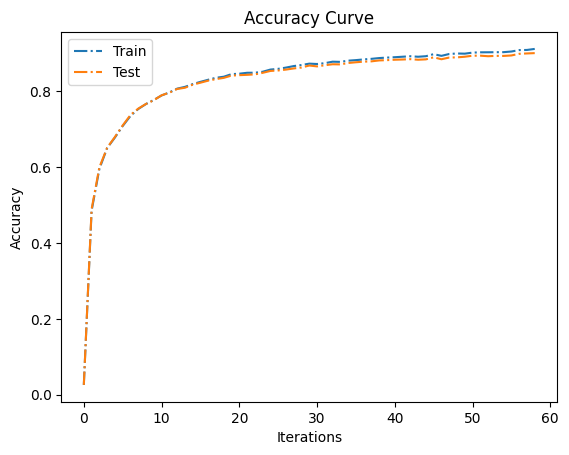

Epoch: 1, Batch: 20000 
Loss0.34761691093444824, Train Accuracy91.10%, Test Accuracy:90.00%


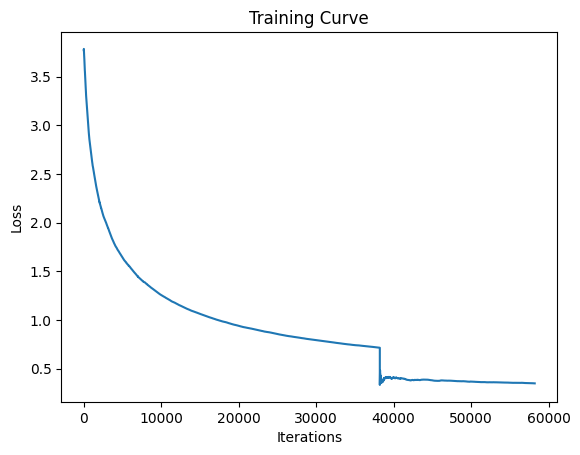

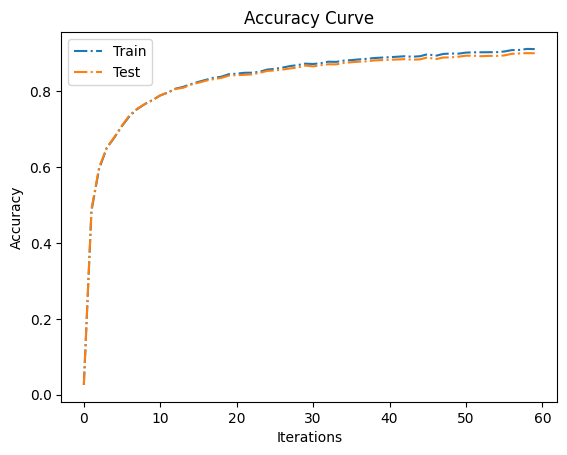

Epoch: 1, Batch: 21000 
Loss0.34694528579711914, Train Accuracy90.93%, Test Accuracy:89.70%


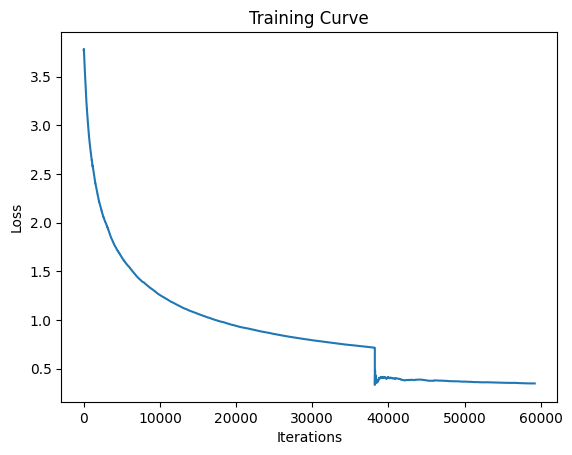

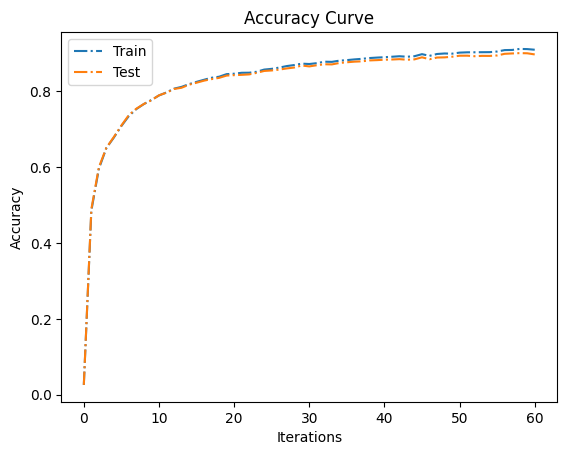

Epoch: 1, Batch: 22000 
Loss0.3472382426261902, Train Accuracy90.82%, Test Accuracy:89.68%


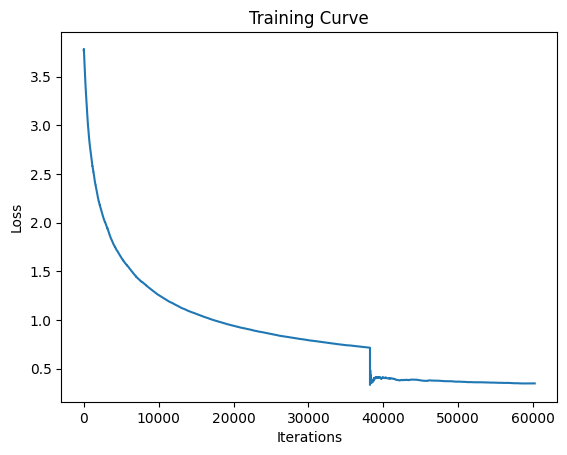

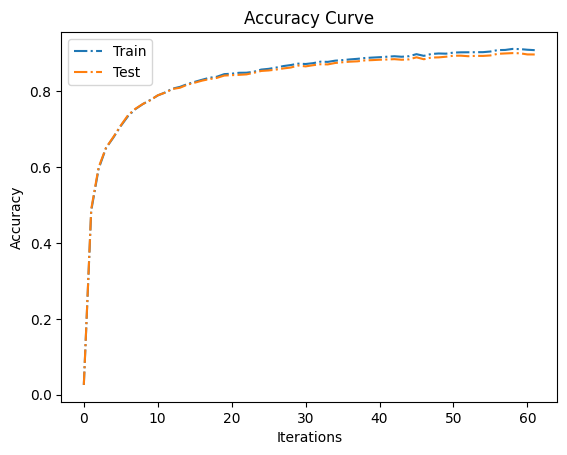

Epoch: 1, Batch: 23000 
Loss0.34394657611846924, Train Accuracy90.69%, Test Accuracy:89.75%


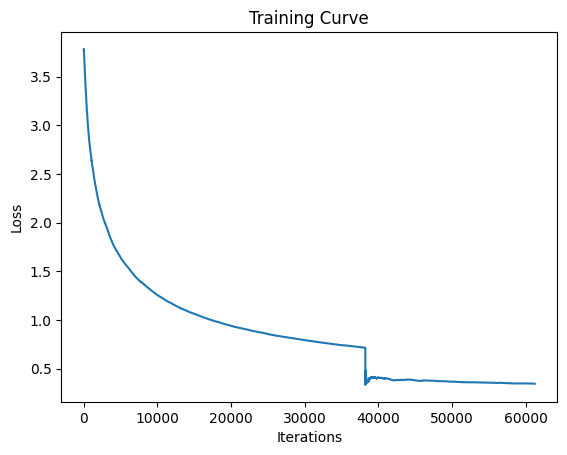

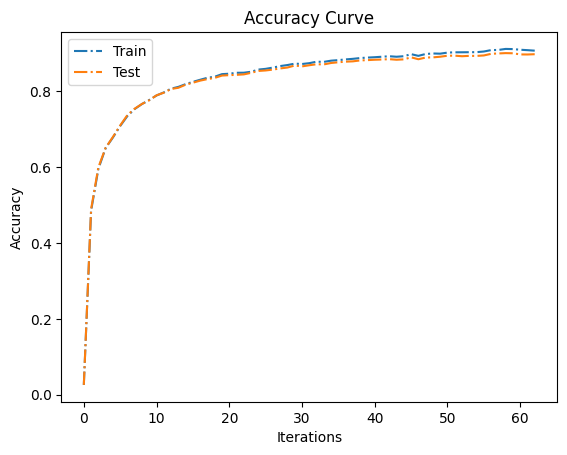

Epoch: 1, Batch: 24000 
Loss0.34363722801208496, Train Accuracy91.03%, Test Accuracy:90.01%


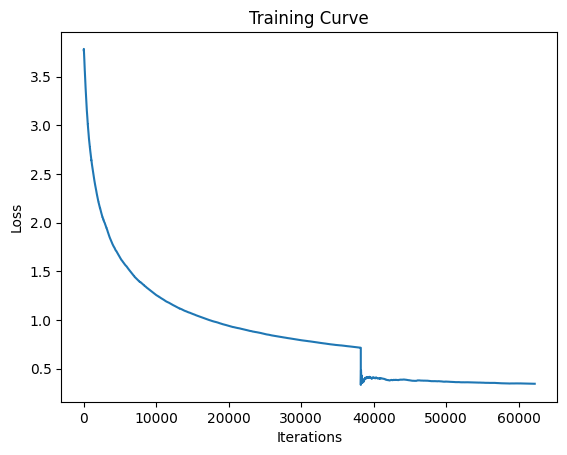

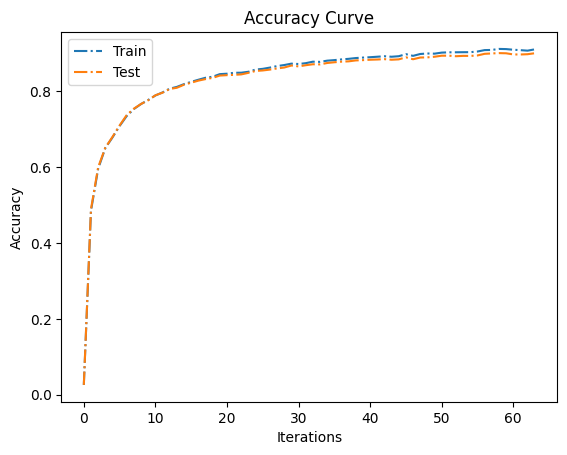

Epoch: 1, Batch: 25000 
Loss0.34058302640914917, Train Accuracy91.20%, Test Accuracy:90.06%


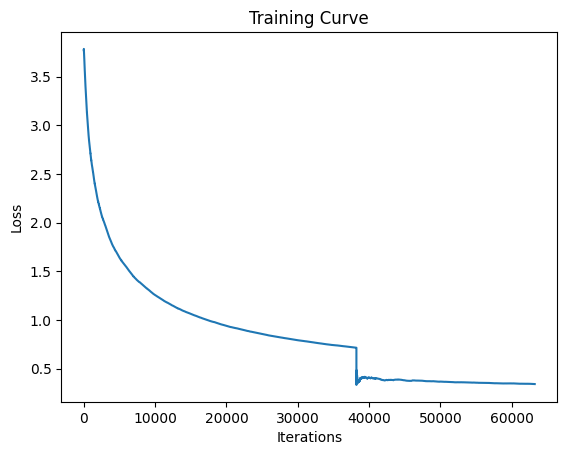

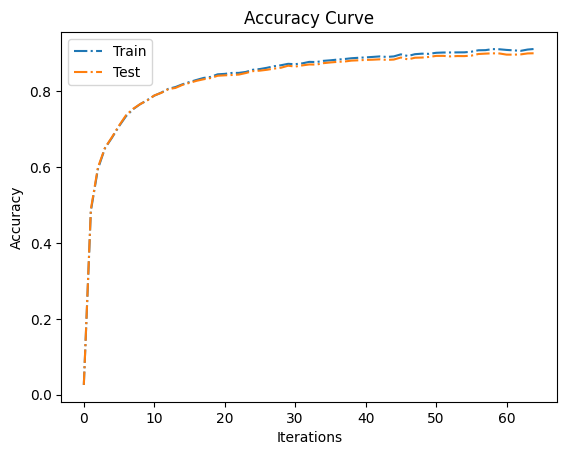

Epoch: 1, Batch: 26000 
Loss0.3384619355201721, Train Accuracy91.12%, Test Accuracy:89.88%


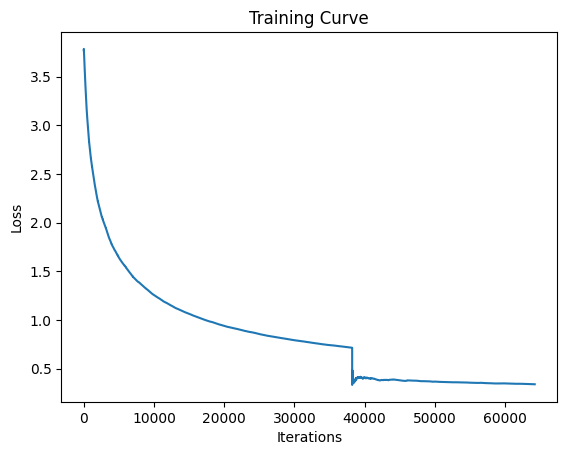

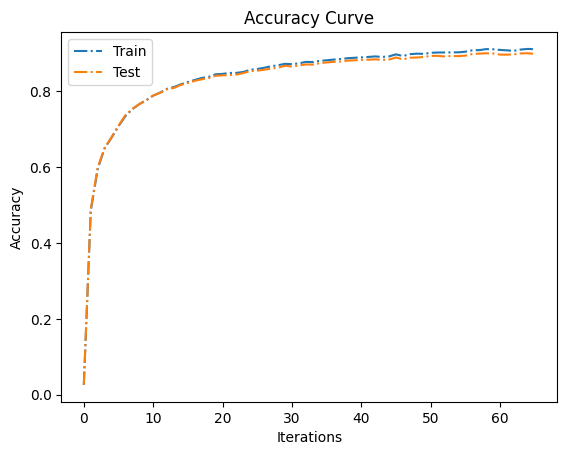

Epoch: 1, Batch: 27000 
Loss0.33767420053482056, Train Accuracy91.34%, Test Accuracy:90.20%


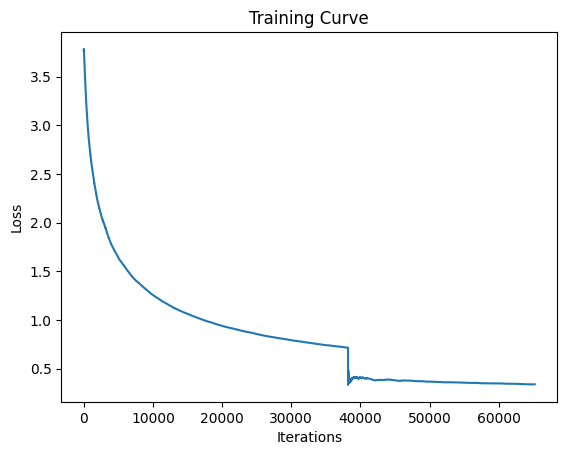

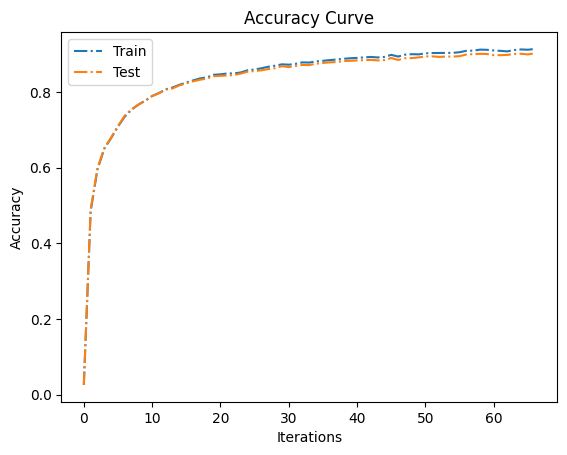

Epoch: 1, Batch: 28000 
Loss0.3371299207210541, Train Accuracy91.45%, Test Accuracy:90.26%


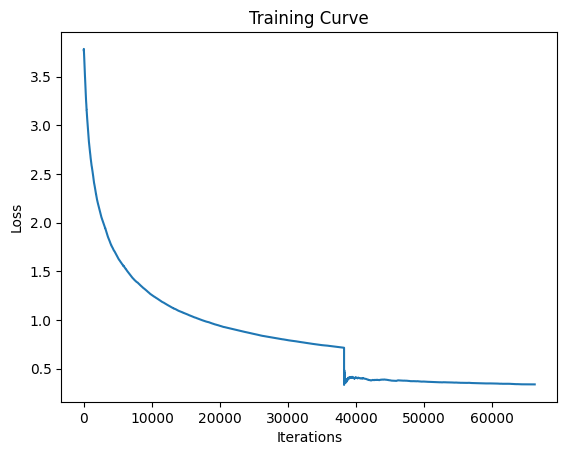

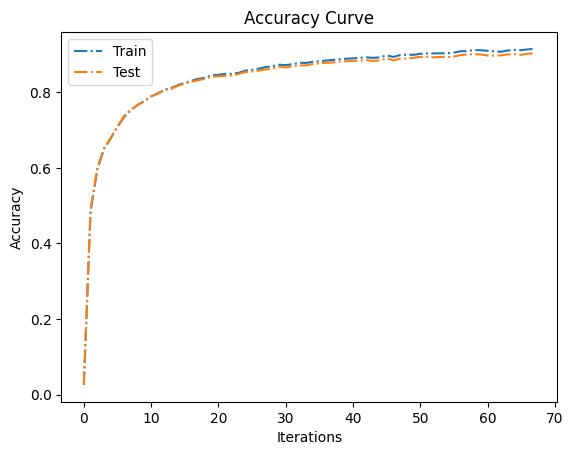

Epoch: 1, Batch: 29000 
Loss0.3359643220901489, Train Accuracy91.75%, Test Accuracy:90.53%


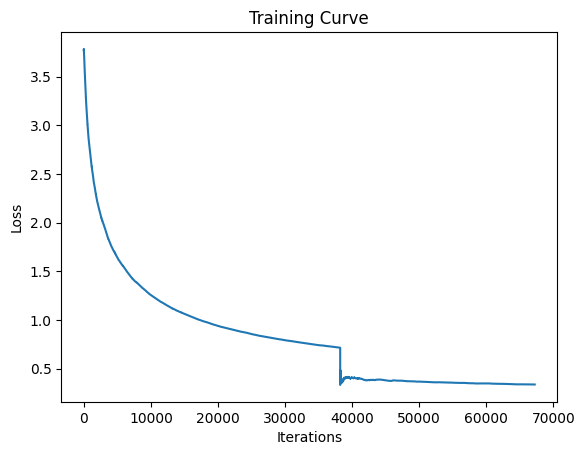

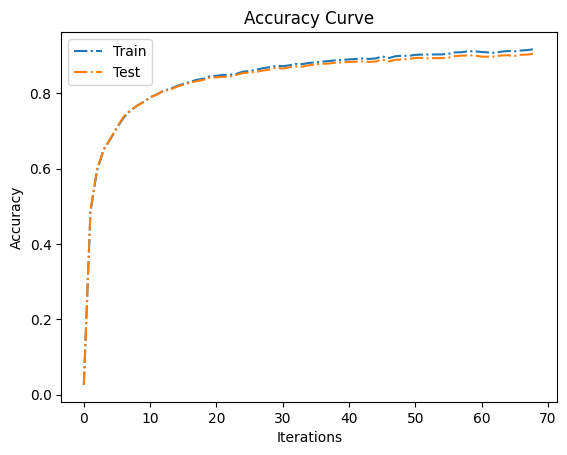

Epoch: 1, Batch: 30000 
Loss0.33487996459007263, Train Accuracy91.43%, Test Accuracy:90.12%


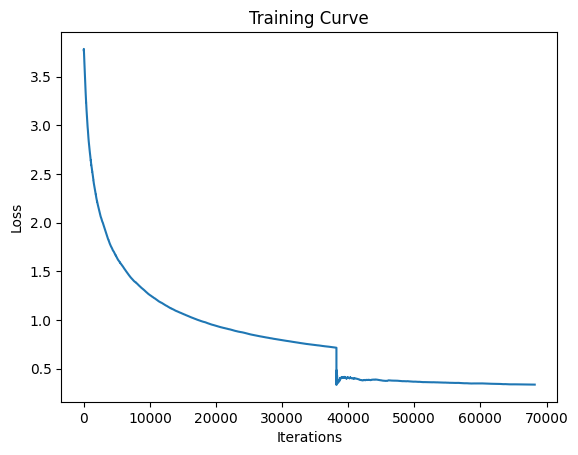

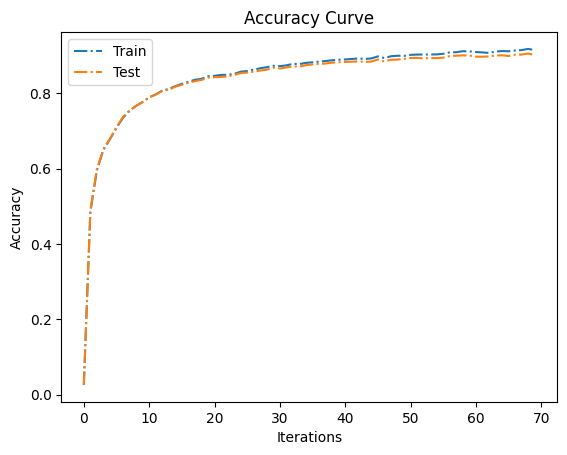

Epoch: 1, Batch: 31000 
Loss0.3348262906074524, Train Accuracy91.44%, Test Accuracy:90.23%


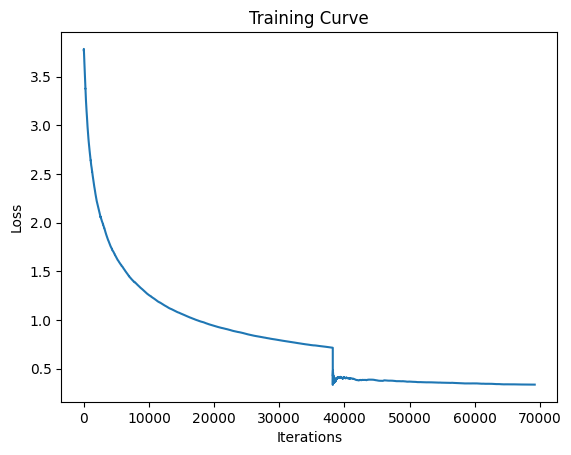

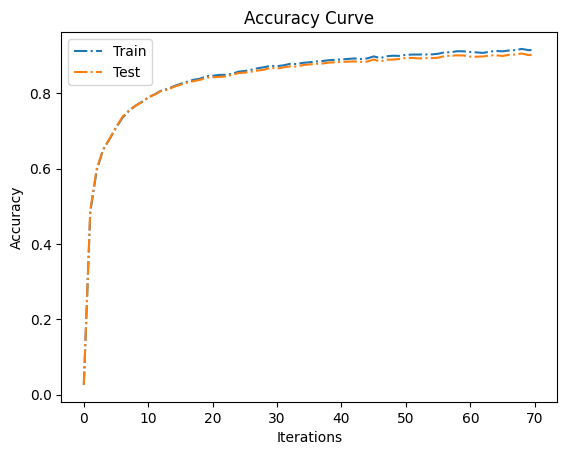

Epoch: 1, Batch: 32000 
Loss0.33371904492378235, Train Accuracy91.73%, Test Accuracy:90.47%


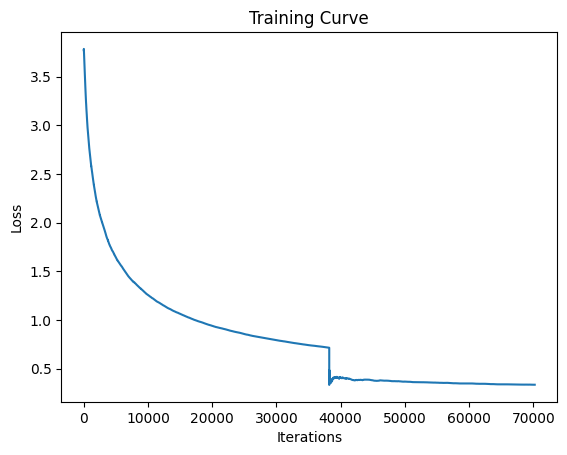

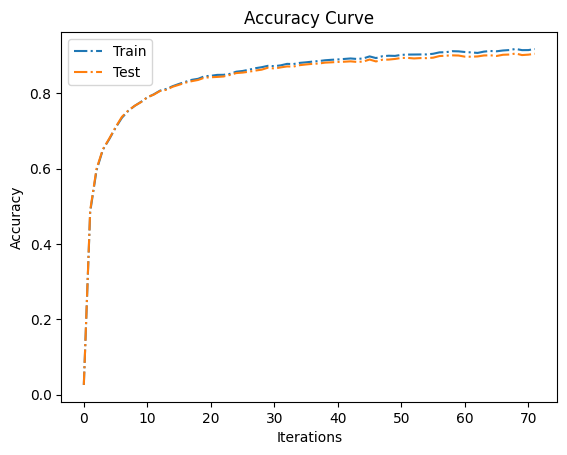

Epoch: 1, Batch: 33000 
Loss0.33268219232559204, Train Accuracy91.54%, Test Accuracy:90.27%


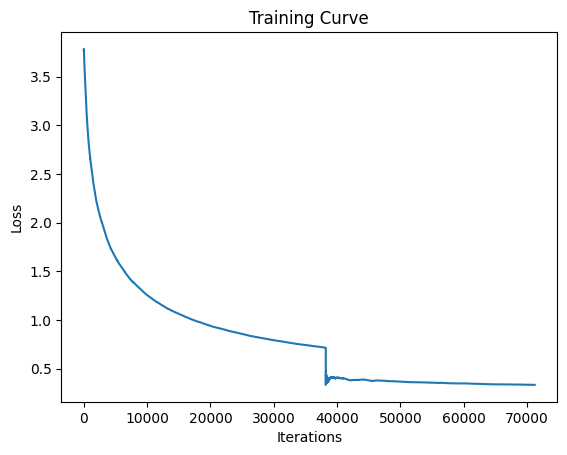

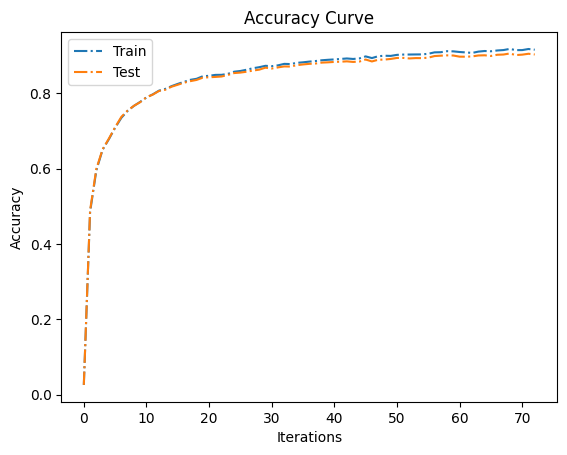

Epoch: 1, Batch: 34000 
Loss0.33103135228157043, Train Accuracy91.73%, Test Accuracy:90.51%


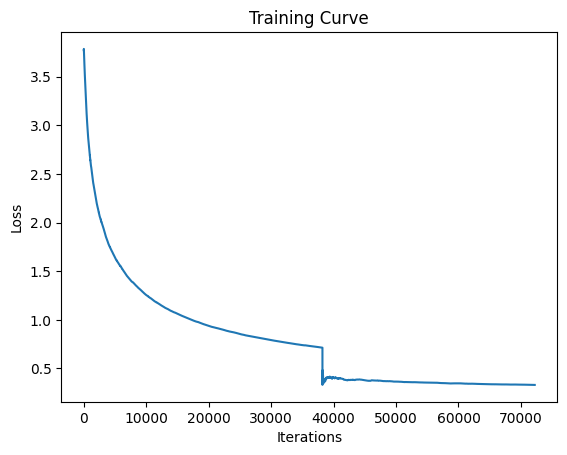

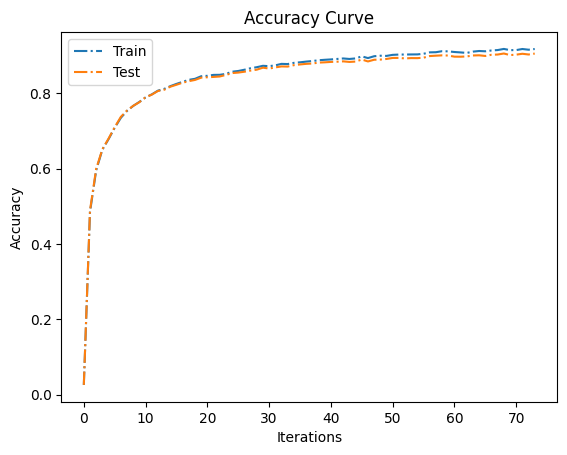

Epoch: 1, Batch: 35000 
Loss0.3297911584377289, Train Accuracy91.66%, Test Accuracy:90.53%


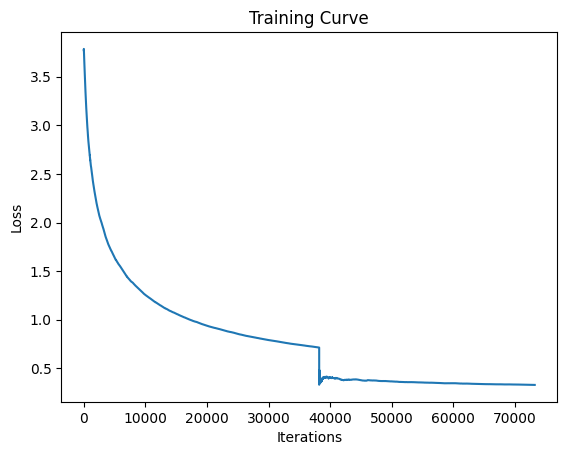

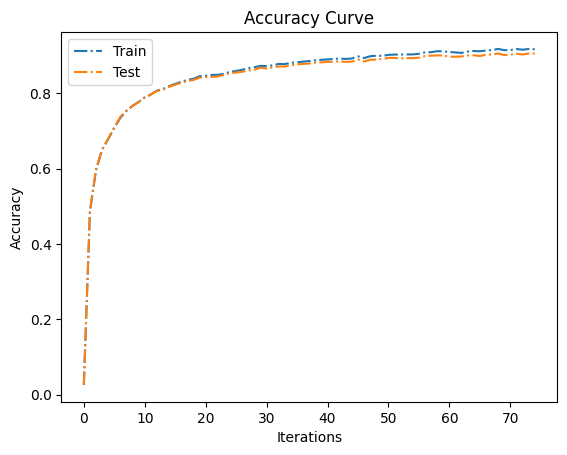

Epoch: 1, Batch: 36000 
Loss0.32984617352485657, Train Accuracy91.83%, Test Accuracy:90.73%


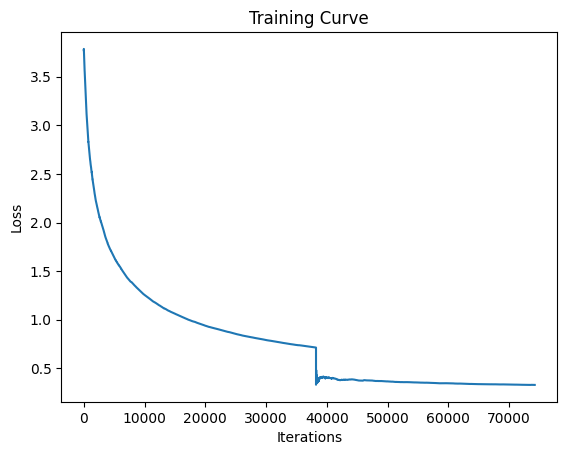

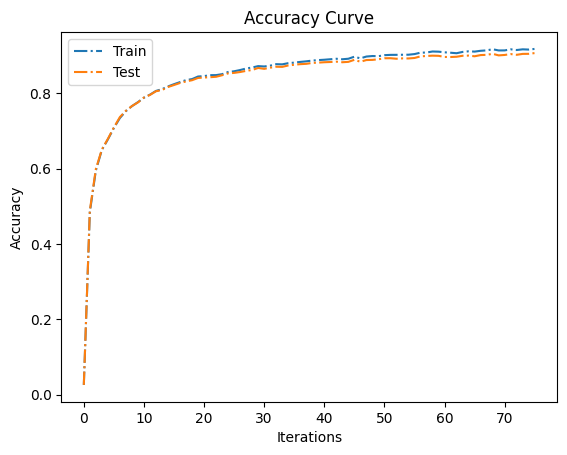

Epoch: 1, Batch: 37000 
Loss0.3291495144367218, Train Accuracy91.93%, Test Accuracy:90.63%


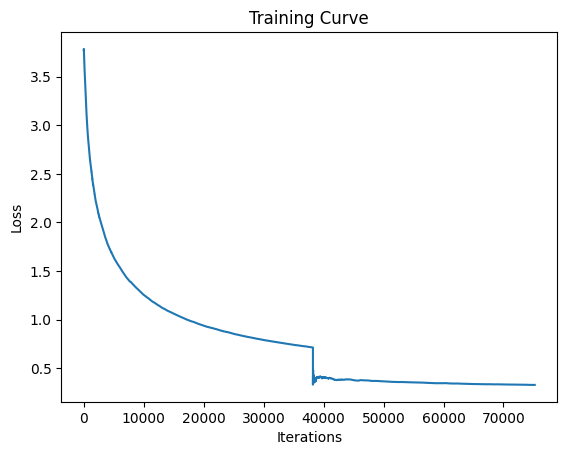

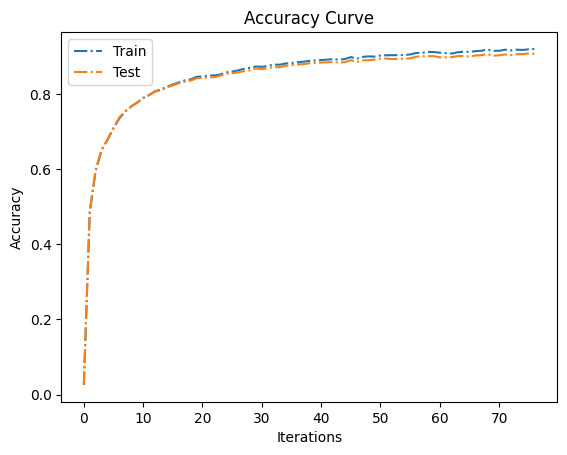

Epoch: 1, Batch: 38000 
Loss0.32742807269096375, Train Accuracy91.92%, Test Accuracy:90.74%


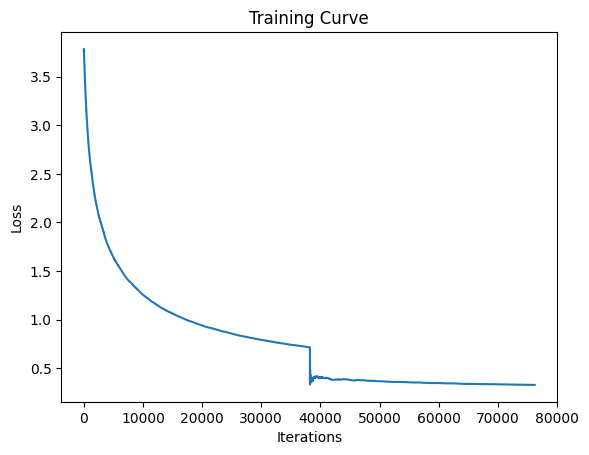

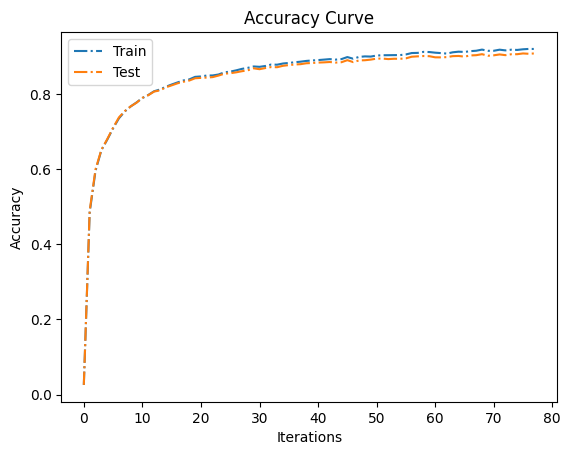

In [75]:
model = LSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, word_vocab_size, tag_vocab_size)
out_model = train(model, lr)